# Cannanetics - Brainstation Capstone Project - Data Collection and Cleaning

Daniel De Biasio
June 28, 2020

The ultimate goal of this project is to be able to link variations in the genome of cannabis strains, determined against a reference strain, to the resulting THC content in the flower of these plants.

Firstly i collect the data that i need. Since the legalities of cannabis have bee so tight until the last few years, the available genetics data is limited. However the open cannabis project existed until a few years ago, collecting public samples of cannabis, which they sequenced, and compared to a reference genome to determine the variations, identifying each variation in the genome by the location in the genome (a range in the genome), and the type of variation, SNP, MNP, insertion, deletion etc. 

The data from this project is still available on Googles BigQuery database, and I first did some pre-processing there as the dataset is so large for all the samples.

The lab samples for the THC content came from the result of a web scrapper which is hosted on GitHub, conveniently hosted as CSV files for each lab. The link to the project is: https://github.com/MaxValue/Terpene-Profile-Parser-for-Cannabis-Strains



In this notebook I cover:

The Genetic Data:

- Preliminary Genetics Data filtering done through Google's BigQuery GUI
- Interacting with the Google BigQuery API
- Loading the data of interest to my local machine
- Data cleaning and Feature Engineering with the Genetic Data


The Lab Data:

- Loading the Data
- Merging and selecting the data of interest from each lab
- Feature Engineering for the Total THC and CBD content

All together:

- Merging the genetic Data, and the lab Data

In [2]:
# First importing our favorite libraries:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

#importing the package to query the google api
#import pandas_gbq


#importing the function for authentication when connecting to googles API
#from google.oauth2 import service_account

#importing re to be able to use regex in the if statements
import re

#importing string, to use its punctuations method
import string

#importing collections to make a dictionary of lists
import collections

#importing fuzzywuzzy to be able to match strings better
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Loading the Data from Googles API locally

To Query the google Big Query API i first had to set my project id, and my credentials to access my project, the project id is the name of the project folder on the Google big Query where i created some tables with the information of interest, from tables copied from the bigquery-public-data:genomics_cannabis folder. The table of most interest was the MNPR01_201703 table, as it contains the actual variant information. and the sample_information table, which contains the unique sample id and cultivar/strain name.

This table was quite large, with data from 1,400 cannabis samples, whose genome was sequenced, and the sequenced genome was processed using the BWA aligner and FreeBayes variant caller, indexed with the Google Genomics API, and exported to BigQuery for analysis. This this table contains over 100,000,000 rows where each row is a variant/mutation found between the a cannabis sample genome, and a reference genome. 

The rows contain a lot of inforamtion about how the aligner aligned the genomes, and the variant caller was able to identify the variant, but the columns of interest for this application are the variant_id, which is the unique id string given to a variation found between the sample genome and the reference genome, based on its location and type, the call_set_name which is the cannabis samples unique id the variant belongs to, and the QUAL column which gives the Phred quality score, which is a measure of how likely the variant is based on the data provided, where a phred score of >20 gives a 99% likelhood of the variation being statistically signifigant.

Since the data set was so big, i initially did a filter using SQL for all the rows which contained those three columns, for variants with QUAL scores >=20, and created a table from the result which i query in this notebook. The table was created using the SQL query:


`SELECT call.call_set_name,  variant_id, call.QUAL
FROM 'capstone-brainstation.cannabis_genome.MNPR01_201703' v,
     v.call
WHERE call.QUAL >=20`

The results from the above query were then stored in another table called capstone-brainstation.cannabis_genome.qual_over_20_with_variant_id.

From this table, i extracted using SQL the rows for samples of interest, determined using the sample information table, shown later in this notebook. 

But first i queried for the sample_info_201703 table information to be downloaded locally.


## Setting up the connection to the Google BiqQuery API

In [4]:
# #setting the project id
# project_id = "capstone-brainstation"

# #setting the access information file
# credentials = service_account.Credentials.from_service_account_file(
#     'C:/Users/danie/Documents/Brainstation - Copy/Capstone Project/google api credentials/Capstone Brainstation-2056a15b7f98.json')

## Downloading the Genetics Sample Information

First, from the original data set, I downloaded the sample_info_201703 table, where every row is information on a genetic sample, and which contains the following columns:

- SRA_Sample_s: a unique sample id
- Sample_Name_s: the original name given to the sample when received, with more information about the sample than just the common strain name
- cultivar_s - the common strain (if there is one) associated with the sample
- Library_Name_s: the library of genetic samples this specific sample comes from 

All the data in these columns are strings.

In [5]:
# #First SQL query - for getting the sample_info_201703 table


# sample_info_table = """

#                     SELECT *
                  
#                     FROM
#                       `capstone-brainstation.cannabis_genome.sample_info_201703`

#                 """

In [6]:
#running the query with pandas_gbq to get the table in a dataframe from the google api, using the project id and credentials from above

#sample_info_table_df = pandas_gbq.read_gbq(sample_info_table, project_id=project_id, credentials=credentials)

In [7]:
#writing this table to a csv for referral later
#sample_info_table_df.to_csv('Data\Genomics Data\sample_info_201703.csv')

In [8]:
#reading the data in again from sample_info_table_df, so i don't have to re run the above sql query

sample_info_table_df = pd.read_csv('Data\Genomics Data\sample_info_201703.csv')

In [9]:
#Checking the import - header
sample_info_table_df.head()

,SRA_Sample_s,Sample_Name_s,cultivar_s,Library_Name_s
0,SRS266493,CS-USO31-DNA,NaN,CS-US_SIL-1
1,SRS266493,CS-USO31-DNA,NaN,CS-US_SIL-2
2,SRS266493,CS-USO31-DNA,NaN,CS-US_SIL-1
3,SRS266493,CS-USO31-DNA,NaN,CS-US_SIL-2
4,SRS266713,CS-FINOLA-DNA,NaN,CS-FN_SIL-1


In [10]:
#Checking the import - footer
sample_info_table_df.tail()

,SRA_Sample_s,Sample_Name_s,cultivar_s,Library_Name_s
1395,SRS1598716,GSM2258376,cv. Santhica 27,NaN
1396,SRS1598716,GSM2258376,cv. Santhica 27,NaN
1397,SRS1598716,GSM2258376,cv. Santhica 27,NaN
1398,SRS1598716,GSM2258376,cv. Santhica 27,NaN
1399,SRS1180044,industrial hemp RNA-Seq,Yunma 5' and 'Bamahuoma',NaN


The SRA is the main means of identifying the sample, and the cultivar is the common strain name i will be using to link the genetics data to my other targets, so i an only interested in the samples which do have the cultivar name.

Here i also notice that the sample_name_s contains information that the sample is a hemp sample, which i do not want to include.

There is a sample which contains hemp, so i will want to check the sample name for the word hemp and remove those samples before removing that column. Since no other sample names contain this kind of valuable information i can drop the sample name column, and the library name column, as the information in these columns is of no use to me. 

In [11]:
#checking which sample names contain hemp
sample_info_table_df[sample_info_table_df['Sample_Name_s'].str.contains('hemp')]

,SRA_Sample_s,Sample_Name_s,cultivar_s,Library_Name_s
1399,SRS1180044,industrial hemp RNA-Seq,Yunma 5' and 'Bamahuoma',NaN


Firstly i want to clean up my data frame, removing that hemp sample, and removing the _s from the column names, and making the column names lower case, along with dropping the unwanted columns.

## Cleaning the Samples Info DataFrame 

The main goal here is to remove hemp samples, and samples without a cultivar/strain name and clean up the strain names so that they represent the correct strain as much as possible. My concerns here are additional numbers placed after the strain name to indicate a sequential sample from the same plant or batch of plants of the same cultivar/strain. Whether they are labelled strain name #123, strain name (3), 'strain name 3', I want to remove the numbers and associated characters.

In [12]:
#making a copy of the raw data, without that hemp sample
sample_info_table_df_clean = sample_info_table_df[~sample_info_table_df['Sample_Name_s'].str.contains('hemp')].copy()

sample_info_table_df_clean.drop(['Sample_Name_s','Library_Name_s'], axis = 1, inplace = True)

sample_info_table_df_clean.columns = ['sra', 'strain']


In [13]:
#Checking the changes

sample_info_table_df_clean

,sra,strain
0,SRS266493,NaN
1,SRS266493,NaN
2,SRS266493,NaN
3,SRS266493,NaN
4,SRS266713,NaN
...,...,...
1394,SRS1598716,cv. Santhica 27
1395,SRS1598716,cv. Santhica 27
1396,SRS1598716,cv. Santhica 27
1397,SRS1598716,cv. Santhica 27


The cultivars of interest are the ones with a strain name, so i only want to keep the sra for samples which have a strain name. 

In [14]:
#Keeping only samples with the strain names present
sample_info_table_df_clean = sample_info_table_df_clean[sample_info_table_df_clean['strain'].notnull()].copy()
sample_info_table_df_clean

,sra,strain
75,SRS1099981,C4
76,SRS1099981,C4
77,SRS1431842,C4
78,SRS1757999,F2
79,SRS1431814,H5
...,...,...
1394,SRS1598716,cv. Santhica 27
1395,SRS1598716,cv. Santhica 27
1396,SRS1598716,cv. Santhica 27
1397,SRS1598716,cv. Santhica 27


Just from the output above i noticed that there are duplicate entries which need to be removed

In [15]:
#Checking for duplicates

sample_info_table_df_clean.duplicated().sum()

118

In [16]:
#dropping the duplicates and keeping only the first entry they appear in 
sample_info_table_df_clean.drop_duplicates(keep='first', inplace=True)

In [17]:
#checking the data frame for nans
sample_info_table_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099 entries, 75 to 1393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sra     1099 non-null   object
 1   strain  1099 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


My next step for cleaning is to standardize the string names, first by making all the names lowercase.

In [18]:
#making all the strain names lower. 
sample_info_table_df_clean.loc[:,'strain'] = sample_info_table_df_clean.loc[:,'strain'].str.lower()

In [19]:
#looking at the unique strain names and their counts
sample_info_table_df_clean['strain'].value_counts()

sour_diesel        14
cv. santhica 27    12
blue_dream          9
cannatonic          9
gorilla_glue_#4     8
                   ..
kauai               1
ogkush              1
tangie_a            1
sourtsunamifem      1
banana_og           1
Name: strain, Length: 842, dtype: int64

I have noticed that the spaces in the strain names are actually '_' so i want to replace those with spaces for consitency

In [20]:
sample_info_table_df_clean.loc[:,'strain'] = sample_info_table_df_clean.loc[:,'strain'].str.replace('_', ' ')

In [21]:
#checking the changes
sample_info_table_df_clean

,sra,strain
75,SRS1099981,c4
77,SRS1431842,c4
78,SRS1757999,f2
79,SRS1431814,h5
80,SRS1431971,j7
...,...,...
1369,SRS1598713,cv. santhica 27
1375,SRS1598714,cv. santhica 27
1381,SRS1598715,cv. santhica 27
1387,SRS1598717,cv. santhica 27


Now i want to check for any strain names which contain the word hemp, and remove them.

In [22]:
#checking which entries contain the word hemp
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('hemp')]

,sra,strain
250,SRS1431841,schemp
548,SRS1758413,ivory hemp
659,SRS1759445,german hemp
687,SRS1759436,polish hemp
770,SRS1758412,markant hemp
884,SRS1759438,romanian hemp
989,SRS1759446,iowa feral hemp
1010,SRS1759447,portuguese hemp
1083,SRS1431856,chp - indica hemp
1094,SRS1758324,hemp cultivar nlh


In [23]:
#Keeping only samples whose name does not contain hemp 
sample_info_table_df_clean = sample_info_table_df_clean[~sample_info_table_df_clean['strain'].str.contains('hemp')].copy()
sample_info_table_df_clean

,sra,strain
75,SRS1099981,c4
77,SRS1431842,c4
78,SRS1757999,f2
79,SRS1431814,h5
80,SRS1431971,j7
...,...,...
1369,SRS1598713,cv. santhica 27
1375,SRS1598714,cv. santhica 27
1381,SRS1598715,cv. santhica 27
1387,SRS1598717,cv. santhica 27


I also happen to know that santhica is a hemp strain so i need to remove entries with this strain from this DataFrame. 

In [24]:
#Keeping only samples whose name does not contain santhica
sample_info_table_df_clean = sample_info_table_df_clean[~sample_info_table_df_clean['strain'].str.contains('santhica')].copy()
sample_info_table_df_clean

,sra,strain
75,SRS1099981,c4
77,SRS1431842,c4
78,SRS1757999,f2
79,SRS1431814,h5
80,SRS1431971,j7
...,...,...
1215,SRS1758080,maleficent conspiracy kush #2
1216,SRS1758089,tyra banks conspiracy kush #5
1217,SRS1758159,kyle kushmans strawberry cough
1218,SRS1758494,malanje local 90's liamba angola


I also want to remove any samples which are for male plants as well, since most growers don't grow them specifically for their THC content.

In [25]:
#checking which samples contain 'male' in the strain name
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('male')].copy()


,sra,strain
361,SRS1107958,ottomale
1206,SRS1107977,blueberrycheesecake11male
1215,SRS1758080,maleficent conspiracy kush #2


In [26]:
#Keeping only the entries which don't contain male in the strain name
sample_info_table_df_clean = sample_info_table_df_clean[~sample_info_table_df_clean['strain'].str.contains('male')].copy()
sample_info_table_df_clean

,sra,strain
75,SRS1099981,c4
77,SRS1431842,c4
78,SRS1757999,f2
79,SRS1431814,h5
80,SRS1431971,j7
...,...,...
1214,SRS1758364,pigmy pot-congo pointe noire
1216,SRS1758089,tyra banks conspiracy kush #5
1217,SRS1758159,kyle kushmans strawberry cough
1218,SRS1758494,malanje local 90's liamba angola


At this point all the easily identifiable strains which are hemp should now be removed.

My next issue is that some strains have been labelled with a number at the end to designate samples taken from the same plant, or batch of plants, rather than being a part of the strain name, like Gorilla glue #4, some samples are also multiple samples from the same strain but indicated with a letter like A, B, C, D etc at the end. 

I want to drop those letters and numbers, to isolate the actual strain name.

First looking at the strain names which contain a #, it looks like some samples were also identified as sample #x by using the '#' sign

In [27]:
#Finding the cultivars which contain the '#' symbol for inspection
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('#')]

,sra,strain
89,SRS1758088,#23
286,SRS1757968,fuku #1
287,SRS1758029,fuku #4
290,SRS1759475,hael #2
318,SRS1758341,ymca #3
319,SRS1758125,#3 pheno
320,SRS1758194,#3 pheno
321,SRS1757988,#5 pheno
322,SRS1760264,#6 pheno
370,SRS1758487,skunk #1


From the above i can also see that there are some samples with 'unknown' as their strain, or pheno, these are samples without a common strain name and can be removed. 

In [28]:
#Removing samples with unknown in their strain name
sample_info_table_df_clean = sample_info_table_df_clean[~sample_info_table_df_clean['strain'].str.contains('unknown')].copy()
sample_info_table_df_clean

,sra,strain
75,SRS1099981,c4
77,SRS1431842,c4
78,SRS1757999,f2
79,SRS1431814,h5
80,SRS1431971,j7
...,...,...
1214,SRS1758364,pigmy pot-congo pointe noire
1216,SRS1758089,tyra banks conspiracy kush #5
1217,SRS1758159,kyle kushmans strawberry cough
1218,SRS1758494,malanje local 90's liamba angola


In [29]:
#looking at samples which contain pheno in the strain name, most are of specifically bred pheno types, not of commonly seen strains
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('pheno')]

,sra,strain
319,SRS1758125,#3 pheno
320,SRS1758194,#3 pheno
321,SRS1757988,#5 pheno
322,SRS1760264,#6 pheno
809,SRS1758007,#2 pheno kfx2
1137,SRS1760342,#5 pheno afghan dom


In [30]:
#removing samples with pheno in the strain name
sample_info_table_df_clean = sample_info_table_df_clean[~sample_info_table_df_clean['strain'].str.contains('pheno')].copy()

In [31]:
#checking which strain names contain '#' again after completing the above
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('#')]

,sra,strain
89,SRS1758088,#23
286,SRS1757968,fuku #1
287,SRS1758029,fuku #4
290,SRS1759475,hael #2
318,SRS1758341,ymca #3
370,SRS1758487,skunk #1
371,SRS1758566,skunk #1
401,SRS1759474,camael #1
488,SRS1967058,az star #2
489,SRS1431887,az star #1


From this list, i know from researching that gorilla glue #4, #23, and 'afghani #1 x skunk #1' are the only strains whose common strain name actually requires the numbers to be identified, the for the rest the numbers are identifiers of either a plant from a batch of plants from the same strain, or a repeat a multiple of samples from the same plant of the same strain.

The goal here is to remove the #2 or #5 for example which indicates a multiple samples from a plant or from a batch of plants from the same strain, while maintaining the numeric values for the strains mentioned above, so i use a string split on the '#' character to the numeric identifiers for except the strains mentioned above.


In [32]:
#removing the #num for certain samples

sample_info_table_df_clean['strain']= sample_info_table_df_clean['strain'].apply(lambda x: x.split(' #')[0] \
                                                        if x not in ['gorilla glue #4', '#23','afghani #1 x skunk #1'] 
                                                       else x)

In [33]:
#checking the results from above, if the cultivars which we excluded stayed the same
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('#')]

,sra,strain
89,SRS1758088,#23
977,SRS1758362,gorilla glue #4
978,SRS1759454,gorilla glue #4
979,SRS1759459,gorilla glue #4
980,SRS1759458,gorilla glue #4
981,SRS1759457,gorilla glue #4
982,SRS1759464,gorilla glue #4
983,SRS1759477,gorilla glue #4
984,SRS1759479,gorilla glue #4
1183,SRS1758495,afghani #1 x skunk #1


Some cultivars may have just a number or two at the end after a space to indicate a plant from a batch of plants from the same strain, or a repeat a multiple of samples from the same plant of the same strain, first i will check for those with one number at the end, then two numbers at the end of their strain name:



In [34]:
#checking which samples have just a number at the end, usually used to indicate a sample with the same strain name

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^.* [0-9]$', regex = True)]

,sra,strain
178,SRS1431886,gin 1
179,SRS1431970,gin 2
196,SRS1107968,pc3 2
214,SRS1760294,chem 4
215,SRS1758297,chem 7
255,SRS1758094,ukaw 1
256,SRS1760341,ukaw 2
457,SRS1431829,og kush 1
470,SRS1431883,snowcap 1
471,SRS1431953,snowcap 2


In [35]:
#checking which samples have two or more numbers at the end, usually used to indicate a sample with the same strain name, with two or more prior characters

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^.{2,} [0-9]$', regex = True)]

,sra,strain
178,SRS1431886,gin 1
179,SRS1431970,gin 2
196,SRS1107968,pc3 2
214,SRS1760294,chem 4
215,SRS1758297,chem 7
255,SRS1758094,ukaw 1
256,SRS1760341,ukaw 2
457,SRS1431829,og kush 1
470,SRS1431883,snowcap 1
471,SRS1431953,snowcap 2


In [36]:
#Removing the numbers off of the samples shown above by splitting at the space for those samples only, 
#and taking everything except the last value from the split, and rejoining it

sample_info_table_df_clean['strain'] = sample_info_table_df_clean['strain'].apply(lambda x: ' '.join(x.split(' ')[:-1])\
                                                        if re.match(r'^.{2,} [0-9]$', x) 
                                                        else x)

Next i look for strain names which end with a number directly after some non numeric characters, i chose 3 non-numeric characters as usually for the strain names with 2 or less non-numeric characters, the numbers after are important, as i have discovered in my research.

In [37]:
# Gettting the samples whose cultivars contain 1 to 3 numbers after non numeric characters in the strain name
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('[a-z]{3}[0-9]{1,}$', regex = True)]

,sra,strain
167,SRS1431869,cbd18
268,SRS1967056,banana2
269,SRS1098406,black84
271,SRS1099976,black84
406,SRS1098403,chemdog91
410,SRS1099979,chemdog91
440,SRS1967047,headband1
623,SRS1967055,black jack1
624,SRS1967053,black jack2
627,SRS1967051,blue dream1


Things like banana2 and blue dream2 and stuff are just repeat samples label used to identify multiple samples taken from the same plant or batch of plants, not important to strain names, so they can be removed. The numbers are important for the strains cbd18, black84, chemdog91, so i exclude those strains when removing the numbers

In [38]:
#checking the lambda function to be applied to the above

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('[a-z]{3,}[0-9]{1,3}$', regex = True)]['strain']\
                                                                .apply(lambda x: ''.join(i for i in x if not i.isdigit()) \
                                                                if (x not in ['cbd18', 'black84','chemdog91']) and (re.search(r'[a-z]{3,}[0-9]{1,3}$', x))\
                                                                else x)

167                  cbd18
268                 banana
269                black84
271                black84
406              chemdog91
410              chemdog91
440               headband
623             black jack
624             black jack
627             blue dream
628             blue dream
871           liberty haze
935          nuclear fruit
1043        ghosttrainhaze
1130     purple kryptonite
1149    laconfidentialprep
Name: strain, dtype: object

In [39]:
#since the lambda function checked out, i can now apply it and remove the numbers at the end of the cultivars of interest

sample_info_table_df_clean['strain'] = sample_info_table_df_clean['strain']\
.apply(lambda x: ''.join(i for i in x if not i.isdigit()) \
                    if (x not in ['cbd18', 'black84','chemdog91']) and (re.search(r'[a-z]{3,}[0-9]{1,3}$', x))\
                    else x)

In [40]:
#looking at the unique cultivars to see how all the strain names look 
sample_info_table_df_clean['strain'].unique()

array(['c4', 'f2', 'h5', 'j7', 'mo', 'r4', 'tj', 'uw', 'vl', 'wz', 'z7',
       '#23', 'b-1', 'c-3', 'c36', 'c37', 'fog', 'flo', 'gsc', 'h11',
       'j20', 'j28', 'jah', 'lsd', 'mex', 'nlm', 'pc3', 'pez', 'ppa',
       'rs2', 'sfv', 'st3', 'xxx', 'acdc', 'adak', 'ak47', 'baox', 'cinx',
       'f-16', 'kwgs', 'kush', 'laos', 'lucy', 'mcog', 'mkla', 'nycd',
       'otto', 'p-91', 'ruby', 'sage', 'star', 'thai', 'toto', 'wifi',
       'xj-b', 'ac/dc', 'afgoo', 'bc hq', 'c-rex', 'cbd-0', 'cbd18',
       'cinex', 'curly', 'dmn-1', 'faith', 'ghana', 'ghost', 'gin',
       'halfy', 'india', 'kauai', 'l.b.k', 'lambo', 'mazar', 'nepal',
       'nuken', 'og 18', 'og 99', 'obama', 'purps', 'recon', 'ringo',
       'taint', 'u-dub', 'waf b', 'xj 13', 'yummy', '4-jack', '619 og',
       '9 mile', 'afghan', 'afghoo', 'banana', 'chem', 'chem d', 'cherry',
       'curtis', 'diablo', 'finola', 'g.s.c.', 'gambia', 'ingrid',
       'kaboom', 'legend', 'lily-1', 'lily-2', 'lily-4', 'malawi',
       'miya

I noticed i still have numeric indicators of repeat strain names for samples, and some non numeric indicators of multiple samples from the same plant or batch of plants i need to remove. 

In [41]:
#cheking for cultivars which contain 0x

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[a-z ]*0[0-9]{1,2}$', regex = True)]

,sra,strain
874,SRS1757948,nyc diesel 01
875,SRS1758439,nyc diesel 06


In [42]:
#removing the 0x from these strain names, 

sample_info_table_df_clean['strain'] = sample_info_table_df_clean['strain']\
                                        .apply(lambda x: ''.join(i for i in x if not i.isdigit()) \
                                        if (x not in ['cbd18', 'black84','chemdog91']) and (re.match(r'^[a-z ]*0[0-9]{1,2}$', x))\
                                        else x)

In [43]:
#checking for cultivars which contain one nonnumeric character at the 
#to indicate a multiple of a sample taken from one plant, or samples taken from the same batch of plants
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]* [a-z]$', regex = True)]

,sra,strain
204,SRS1431812,waf b
216,SRS1760314,chem d
373,SRS1760347,tangie a
374,SRS1757959,tangie c
487,SRS1758445,yarkhun e
596,SRS1758257,snowland a
633,SRS1758360,champagne x
666,SRS1758121,grape god a
723,SRS1758404,tanzanian a
724,SRS1757939,tanzanian b


In [44]:
#since the x in champagne x is important and part of that strains name, i need to limit my search to include only up to w then 
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]* [a-w]$', regex = True)]

,sra,strain
204,SRS1431812,waf b
216,SRS1760314,chem d
373,SRS1760347,tangie a
374,SRS1757959,tangie c
487,SRS1758445,yarkhun e
596,SRS1758257,snowland a
666,SRS1758121,grape god a
723,SRS1758404,tanzanian a
724,SRS1757939,tanzanian b
725,SRS1760276,tanzanian c


In [45]:
#checking the removal lambda function for removing the single non numeric character at the end of these strain names

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]* [a-w]$', regex = True)]['strain'].apply(lambda x: ' '.join(x.split(' ')[:-1])\
                                                        if re.match(r'^[1-z ]* [a-w]$', x) 
                                                        else x)

204                        waf
216                       chem
373                     tangie
374                     tangie
487                    yarkhun
596                   snowland
666                  grape god
723                  tanzanian
724                  tanzanian
725                  tanzanian
798                 trainwreck
799                 trainwreck
800                 trainwreck
804                 white fire
870                lemon skunk
1119          chocolate heaven
1200    east coast sour diesel
Name: strain, dtype: object

In [46]:
#removing the single non numeric character at the end of these strain names
sample_info_table_df_clean['strain']=sample_info_table_df_clean['strain'].apply(lambda x: ' '.join(x.split(' ')[:-1])\
                                                        if re.match(r'^[1-z ]* [a-c]$', x) 
                                                        else x)

In [47]:
#checking the unique strain names again
sample_info_table_df_clean['strain'].unique()

array(['c4', 'f2', 'h5', 'j7', 'mo', 'r4', 'tj', 'uw', 'vl', 'wz', 'z7',
       '#23', 'b-1', 'c-3', 'c36', 'c37', 'fog', 'flo', 'gsc', 'h11',
       'j20', 'j28', 'jah', 'lsd', 'mex', 'nlm', 'pc3', 'pez', 'ppa',
       'rs2', 'sfv', 'st3', 'xxx', 'acdc', 'adak', 'ak47', 'baox', 'cinx',
       'f-16', 'kwgs', 'kush', 'laos', 'lucy', 'mcog', 'mkla', 'nycd',
       'otto', 'p-91', 'ruby', 'sage', 'star', 'thai', 'toto', 'wifi',
       'xj-b', 'ac/dc', 'afgoo', 'bc hq', 'c-rex', 'cbd-0', 'cbd18',
       'cinex', 'curly', 'dmn-1', 'faith', 'ghana', 'ghost', 'gin',
       'halfy', 'india', 'kauai', 'l.b.k', 'lambo', 'mazar', 'nepal',
       'nuken', 'og 18', 'og 99', 'obama', 'purps', 'recon', 'ringo',
       'taint', 'u-dub', 'waf', 'xj 13', 'yummy', '4-jack', '619 og',
       '9 mile', 'afghan', 'afghoo', 'banana', 'chem', 'chem d', 'cherry',
       'curtis', 'diablo', 'finola', 'g.s.c.', 'gambia', 'ingrid',
       'kaboom', 'legend', 'lily-1', 'lily-2', 'lily-4', 'malawi',
       'miyagi

It appears i still have -xx as repeat sample indicators, and a (a2) which i need to remove

In [48]:
#checking for cultivars which contain a dash and a number at the end
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]*-[0-9]{1,}$', regex = True)]

,sra,strain
90,SRS1431811,b-1
91,SRS1760313,c-3
128,SRS1757977,f-16
142,SRS1758250,p-91
143,SRS1759492,p-91
166,SRS1431868,cbd-0
174,SRS1431849,dmn-1
229,SRS1758085,lily-1
230,SRS1758122,lily-2
231,SRS1757964,lily-4


For thos samples whose strain name is less than 3 characters prior to the '-' the number is a part of their name and needs to be kept.

In [49]:
#checking for cultivars which contain a dash and a number at the end, 
#and have more than 2 numeric or non nemeric columns prior to the '-'
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]{2,}-[0-9]{1,}$', regex = True)]

,sra,strain
166,SRS1431868,cbd-0
174,SRS1431849,dmn-1
229,SRS1758085,lily-1
230,SRS1758122,lily-2
231,SRS1757964,lily-4
657,SRS1431840,g13 haze-31
664,SRS1431926,grape ak-47
716,SRS1431880,spectrum-11
717,SRS1431882,spectrum-14
831,SRS1431846,cbd shark f-6


For grape ak-47, the -47 is important and part of the strain name so i dont want to remove it.

In [50]:
#cheking the lambda function for removing the '-XX' of the strains above

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]{2,}-[0-9]{1,}$', regex = True)]['strain']\
                                                                .apply(lambda x: ' '.join(x.split('-')[:-1])\
                                                                if re.match(r'^[1-z ]{2,}-[0-9]{1,}$', x) and (x != 'grape ak-47')
                                                                else x)

166             cbd
174             dmn
229            lily
230            lily
231            lily
657        g13 haze
664     grape ak-47
716        spectrum
717        spectrum
831     cbd shark f
942    remedy 29 19
Name: strain, dtype: object

In [51]:
#Applying the above lambda function

sample_info_table_df_clean['strain'] = sample_info_table_df_clean['strain'].apply(lambda x: ' '.join(x.split('-')[:-1])\
                                                        if re.match(r'^[1-z ]{2,}-[0-9]{1,}$', x) and (x != 'grape ak-47')
                                                        else x)

In [52]:
#checking that grape ak-47 is still there.
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('^[1-z ]{2,}-[0-9]{1,}$', regex = True)]

,sra,strain
664,SRS1431926,grape ak-47


In [53]:
#lastly i want to see if any strain names contain ()

sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('\(.*\)', regex = True)]

,sra,strain
465,SRS1431824,r4-2 (a2)


In [54]:
#Checking the effect of  lambda function to remove the () 
sample_info_table_df_clean[sample_info_table_df_clean['strain'].str.contains('\(.*\)', regex = True)]['strain']\
                                                                .apply(lambda x: ' '.join(x.split(' (')[:-1]))

465    r4-2
Name: strain, dtype: object

In [55]:
#Applying the effect of  lambda function to remove the () 

sample_info_table_df_clean['strain'] = sample_info_table_df_clean['strain']\
                                        .apply(lambda x: ' '.join(x.split(' (')[:-1]) if re.match('\(.*\)', x) else x)

In [56]:
#checking the unique strain names again to see if there is anything else i need to remove to standardize the names

sample_info_table_df_clean['strain'].unique()

array(['c4', 'f2', 'h5', 'j7', 'mo', 'r4', 'tj', 'uw', 'vl', 'wz', 'z7',
       '#23', 'b-1', 'c-3', 'c36', 'c37', 'fog', 'flo', 'gsc', 'h11',
       'j20', 'j28', 'jah', 'lsd', 'mex', 'nlm', 'pc3', 'pez', 'ppa',
       'rs2', 'sfv', 'st3', 'xxx', 'acdc', 'adak', 'ak47', 'baox', 'cinx',
       'f-16', 'kwgs', 'kush', 'laos', 'lucy', 'mcog', 'mkla', 'nycd',
       'otto', 'p-91', 'ruby', 'sage', 'star', 'thai', 'toto', 'wifi',
       'xj-b', 'ac/dc', 'afgoo', 'bc hq', 'c-rex', 'cbd', 'cbd18',
       'cinex', 'curly', 'dmn', 'faith', 'ghana', 'ghost', 'gin', 'halfy',
       'india', 'kauai', 'l.b.k', 'lambo', 'mazar', 'nepal', 'nuken',
       'og 18', 'og 99', 'obama', 'purps', 'recon', 'ringo', 'taint',
       'u-dub', 'waf', 'xj 13', 'yummy', '4-jack', '619 og', '9 mile',
       'afghan', 'afghoo', 'banana', 'chem', 'chem d', 'cherry', 'curtis',
       'diablo', 'finola', 'g.s.c.', 'gambia', 'ingrid', 'kaboom',
       'legend', 'lily', 'malawi', 'miyagi', 'munkey', 'nepali', 'ogkush',


In [57]:
#finally i want to remove all punctuation marks

for i in string.punctuation:
    sample_info_table_df_clean['strain']= sample_info_table_df_clean['strain'].str.replace(i, '')

In [58]:
#I saved this as a csv to be able to work directly with it without having 
# to re run the above if i come back to this notebook later

#sample_info_table_df_clean.to_csv('cleaned_sra_strain_name_copy2_2wb.csv', index = False)

In [59]:
#checking the number of unique cultivars
len(sample_info_table_df_clean['strain'].unique())

754

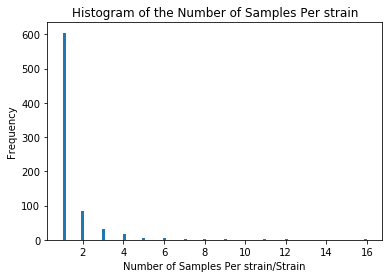

In [60]:
#Looking at how many genetic samples each unique strain has

plt.figure()
plt.hist(sample_info_table_df_clean['strain'].value_counts(), bins = 100)
plt.xlabel('Number of Samples Per strain')
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Samples Per strain')
plt.show()

I can see now that i have 754 unique strain names, with most having only 1-2 genetic samples for them.

In [61]:
#just before i continue i want to check if i have duplicated genetic samples,
#by checking for duplicate unique sample identifiers

sample_info_table_df_clean['sra'].duplicated().sum()

0

## Downloading the Genetic Data for the Narrowed Down Samples Using Google API 

Since i was having issues downloading the large data set Googles BigQuery, what i did was first make another table through Googles BigQuery GUI, as mentioned above using SQL for all the rows which contained the three columns of interest, the unique sample id column, the variant id column and the QUAL column, for variants with QUAL scores >=20, and created a table from the result which i query below. 

The table was created using the SQL query:


`SELECT call.call_set_name,  variant_id, call.QUAL
FROM 'capstone-brainstation.cannabis_genome.MNPR01_201703' v,
     v.call
WHERE call.QUAL >=20`

The results from the above query were then stored in another table called capstone-brainstation.cannabis_genome.qual_over_20_with_variant_id.

Using a for loop i pulled the rows from this table which correspond to the samples in the cleaned sample info dataframe from above, so i could extract only the information i needed.

In [62]:
# #using the sra values (the unique sample identifier) in the above dataframe, extracting only the rows i needed.

# all_canna_sample_data = pd.DataFrame()
# count = 1
# total_samples = len(sample_info_table_df_clean)

# for sra in sra_freq_cult['sra']:
#     print(f'adding {sra} : {count} of {total_samples}')
#     canna_sample = f"""

#                                 SELECT *
#                                 FROM
#                                   `capstone-brainstation.cannabis_genome.qual_over_20_with_variant_id`

#                                 WHERE call_set_name = '{sra}'

#                                 """
    
#     canna_sample_df = pandas_gbq.read_gbq(canna_sample, project_id=project_id, credentials=credentials)  
#     all_canna_sample_data_1 = pd.concat([all_canna_sample_data_1, canna_sample_df], axis = 0)

#     count+=1

In [63]:
#saving the data collected from above, as not to have to rerun the process
#all_canna_sample_data.to_csv('all_canna_sample_data_0123.csv')

In [3]:
#Re-importing the data to work with it

all_canna_sample_data = pd.read_csv('C:/Users/danie/Documents/Brainstation - Copy/Capstone Project/all_canna_sample_data_0123.csv')

In [4]:
#Checking the import for header issues

all_canna_sample_data.head()

,Unnamed: 0,call_set_name,variant_id,QUAL
0,0,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0ODg4MjB8Z2J8TU5QUj...,117.1600
1,1,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTcwMTl8Z2J8TU5QUj...,34.7056
2,2,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU0ODh8Z2J8TU5QUj...,64.4961
3,3,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2ODF8Z2J8TU5QUj...,57.2685
4,4,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQxOTN8Z2J8TU5QUj...,58.3126


In [5]:
#Checking the import for footer issues

all_canna_sample_data.tail()

,Unnamed: 0,call_set_name,variant_id,QUAL
62772863,553,SRS1098406,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU1OTV8Z2J8TU5QUj...,37.3363
62772864,554,SRS1098406,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2MzB8Z2J8TU5QUj...,61.9962
62772865,555,SRS1098406,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTUwMzZ8Z2J8TU5QUj...,60.1083
62772866,556,SRS1098406,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQzNzV8Z2J8TU5QUj...,56.3252
62772867,557,SRS1098406,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTYxMzN8Z2J8TU5QUj...,60.1096


In [6]:
#removing the old index column 'Unnamed: 0'
all_canna_sample_data.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
#dropping the 'QUAL' column since i don't need it
all_canna_sample_data = all_canna_sample_data.drop(columns = 'QUAL')

In [8]:
#cheking for null values
all_canna_sample_data.isnull().any().sum()

0

In [69]:
#Re-Checking the dataframe

all_canna_sample_data.head()

,call_set_name,variant_id
0,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0ODg4MjB8Z2J8TU5QUj...
1,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTcwMTl8Z2J8TU5QUj...
2,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU0ODh8Z2J8TU5QUj...
3,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2ODF8Z2J8TU5QUj...
4,SRS1107944,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQxOTN8Z2J8TU5QUj...


One thing i want to do here is actually get the number of variants for each sample first.

In [70]:
#getting the variant number in each unique sample
variant_number_by_sample = all_canna_sample_data.groupby('call_set_name').count().reset_index()

In [71]:
#setting the column names for the new dataframe with the count of the varaints in each sample

variant_number_by_sample.columns = ['sra', 'num_variants']

As you can see the variant_id is a long string of numbers, which takes up a lot of memory, so i want to reduce the number of characters and make it easy to read.

The call_set_name is the unique genetic sample id as seen in the cleaned sample info dataframe.

## Mapping the Variants for Ease of Reading

My idea here is to map each of the unique variant labels to be something like type_xxxx where the x's are numbers, and then apply this map to the original variant id's, to replace them with this new id style.

In [72]:
#first getting all the unique variant_id's
unique_variant_id= all_canna_sample_data['variant_id'].unique()

In [73]:
#making my dataframe to map the unique variants to a new easy to read id, 
variant_id_map_df = pd.DataFrame(columns = ['variant_id', 'mapped_variant'])
variant_id_map_df['variant_id']=unique_variant_id


In [74]:
# resetting the index, as i am planning to use the index number as the xxxx in the type_xxxx i will assign each variant id
variant_id_map_df.reset_index(inplace = True)

In [75]:
#adding one to the index so i don't get a type_0 mapped variant id, more for asthetic reasons more than anything
variant_id_map_df['mapped_variant'] = variant_id_map_df["index"] +1

In [76]:
#checking the Dataframe so far
variant_id_map_df.head()

,index,variant_id,mapped_variant
0,0,CKXG8eKP9qOf8wESIGdpfDEwOTg0ODg4MjB8Z2J8TU5QUj...,1
1,1,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTcwMTl8Z2J8TU5QUj...,2
2,2,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU0ODh8Z2J8TU5QUj...,3
3,3,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2ODF8Z2J8TU5QUj...,4
4,4,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQxOTN8Z2J8TU5QUj...,5


In [77]:
#dropping the index column since i don't need it anymore

variant_id_map_df.drop(columns ='index', inplace = True)

In [78]:
#looking at the result
variant_id_map_df.head()

,variant_id,mapped_variant
0,CKXG8eKP9qOf8wESIGdpfDEwOTg0ODg4MjB8Z2J8TU5QUj...,1
1,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTcwMTl8Z2J8TU5QUj...,2
2,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU0ODh8Z2J8TU5QUj...,3
3,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2ODF8Z2J8TU5QUj...,4
4,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQxOTN8Z2J8TU5QUj...,5


In [79]:
#adding the type_ to the number in the mapped variant column
variant_id_map_df['mapped_variant'] = 'type_' + variant_id_map_df['mapped_variant'].astype(str)

In [80]:
#checking the result
variant_id_map_df.head()

,variant_id,mapped_variant
0,CKXG8eKP9qOf8wESIGdpfDEwOTg0ODg4MjB8Z2J8TU5QUj...,type_1
1,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTcwMTl8Z2J8TU5QUj...,type_2
2,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTU0ODh8Z2J8TU5QUj...,type_3
3,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTY2ODF8Z2J8TU5QUj...,type_4
4,CKXG8eKP9qOf8wESIGdpfDEwOTg0OTQxOTN8Z2J8TU5QUj...,type_5


Now with this map dataframe, i can do an inner merge with the all_canna_sample_data dataframe, to match the variant_id in each row of that dataframe, to the new mapped variant.

In [81]:
#Doing the inner merge as mentioned above
all_canna_sample_data_mapped = all_canna_sample_data.merge(variant_id_map_df, on = 'variant_id', how = 'inner')

I also check the shape of both dataframes to ensure that everything went according to plan, i should have the same number of rows as the original all_canna_sample_data dataframe

In [82]:
#getting the shape of the dataframe resulting from the merge
all_canna_sample_data_mapped.shape

(62772868, 3)

In [83]:
#getting the shape of the original dataframe used in the merge
all_canna_sample_data.shape

(62772868, 2)

Great, looks like it went according to plan. 

In [84]:
#saving the raw merged dataframe just in case
#all_canna_sample_data_mapped.to_csv('all_canna_sample_data_sra_cultivar_variant_mapped_raw_2.csv')

In [85]:
#now that i have the mapped variants in place, i can now drop the original variant_id column since i won;t be using that.
all_canna_sample_data_mapped.drop(columns = 'variant_id', inplace = True)

#cheking the drop
all_canna_sample_data_mapped.head()

,call_set_name,mapped_variant
0,SRS1107944,type_1
1,SRS1107944,type_1
2,SRS1107944,type_2
3,SRS1107944,type_2
4,SRS1107951,type_2


In [86]:
#changing the call_set_name column label to be sra

all_canna_sample_data_mapped.columns = ['sra', 'mapped_variant']

In [87]:
all_canna_sample_data_mapped.head()

,sra,mapped_variant
0,SRS1107944,type_1
1,SRS1107944,type_1
2,SRS1107944,type_2
3,SRS1107944,type_2
4,SRS1107951,type_2


In [88]:
#saving this dataframe to csv just incase

#all_canna_sample_data_mapped.to_csv('all_canna_sample_data_sra_cultivar_mapped_2.csv')

Now, every row is still one variant that exists in that genetic samples genome, in a specific location range in the genome, so it is possible to have more than one of the same variants in the same location range, so looking for duplicates here does not apply.

I do not want to keep the variant information here in this row form, i want one row for each genetic sample, and a list of the mapped variants for the sample in another column, which I do below.

In [89]:
#making the dataframe described above, one row for each cannabis sample, with a column containing a list of the variants
#for that cannabis sample


all_canna_sample_data_variant_mapped_list = pd.DataFrame(all_canna_sample_data_mapped.groupby('sra')['mapped_variant'].apply(', '.join)).reset_index()

In [90]:
#Checking the new dataframe
all_canna_sample_data_variant_mapped_list.head()

,sra,mapped_variant
0,SRS1098403,"type_708, type_708, type_708, type_708, type_1..."
1,SRS1098404,"type_7804, type_7804, type_30623, type_30623, ..."
2,SRS1098405,"type_7996, type_7996, type_17465, type_17465, ..."
3,SRS1098406,"type_11189, type_11189, type_99746, type_99746..."
4,SRS1098407,"type_28361, type_28361, type_38528, type_38528..."


Now i can merge this dataframe to the cleaned up strain names, on the matching sample id's

In [91]:
#performing the merge described above
all_canna_sample_data_variant_mapped_list = sample_info_table_df_clean\
                                            .merge(all_canna_sample_data_variant_mapped_list, on = 'sra', how = 'inner')

In [92]:
#checking the merge
all_canna_sample_data_variant_mapped_list.head()

,sra,strain,mapped_variant
0,SRS1099981,c4,"type_708, type_708, type_5041, type_5041, type..."
1,SRS1757999,f2,"type_1651, type_2048, type_2274, type_3923, ty..."
2,SRS1758342,r4,"type_2048, type_2274, type_8670, type_11051, t..."
3,SRS1758561,tj,"type_2048, type_2274, type_5097, type_11051, t..."
4,SRS1758102,uw,"type_2048, type_2274, type_5097, type_8083, ty..."


To this dataframe i also want to add a column which lets me know how many variants that specific sample has in its genome:

In [93]:
#Adding the number of variants to the the dataframe with the mapped variant list
all_canna_sample_data_variant_mapped_list = all_canna_sample_data_variant_mapped_list.merge(variant_number_by_sample,  on = 'sra', how = 'inner')

In [94]:
#checking the addition
all_canna_sample_data_variant_mapped_list.head()

,sra,strain,mapped_variant,num_variants
0,SRS1099981,c4,"type_708, type_708, type_5041, type_5041, type...",14300
1,SRS1757999,f2,"type_1651, type_2048, type_2274, type_3923, ty...",4425
2,SRS1758342,r4,"type_2048, type_2274, type_8670, type_11051, t...",3977
3,SRS1758561,tj,"type_2048, type_2274, type_5097, type_11051, t...",3566
4,SRS1758102,uw,"type_2048, type_2274, type_5097, type_8083, ty...",3680


In [95]:
#saving this dataframe just in case
#all_canna_sample_data_variant_mapped_list.to_csv('all_canna_sample_data_variant_mapped_list_2.csv', index = False)

At this point the genetic data is where i would like it to be.

# Lab Data - for THC and CBD

In a perfect world I would have the results of multiple lab analysis tests for flower collected specifically from these strains. Unfortunately this information is not available.

To make the best approximation what i plan on doing is collecting as many lab samples as i can within reason for cannabis flower samples, of as many strains as possible, and matching the genetic data to as many lab samples as possible using the strain name to link the genetics data, to the lab samples.

The lab data i collected was previously scrapped from three lab websites, SciLabs, Analytical 360, and PSILabs, by someone on github, link here:  https://github.com/MaxValue/Terpene-Profile-Parser-for-Cannabis-Strains, downloaded as csv files.


## Scilabs Data

### Loading the data

In [10]:
#Importing the data

scilabs = pd.read_csv('Data/chemotype/Terpene-Profile-Parser-for-Cannabis-Strains/sclabs/terpene and cannabinoids results - sclabs.csv')

In [11]:
#Checking for header issues
scilabs.head()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,trans-Nerolidol 2,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
0,NaN,Vapenit Extracts Moon Rocks,"Flower, Inhalable",2/16/2017,NaN,348,NaN,NaN,NaN,NaN,...,0.17,1.92,0.05,0.15,0.00,0.05,0.23,0.73,0.07,NaN
1,NaN,Tokyo OG,"Flower, Inhalable",8/21/2017,NaN,211,NaN,NaN,NaN,NaN,...,0.07,0.00,0.04,0.00,0.00,0.00,0.53,0.28,0.13,NaN
2,NaN,PSCR-634,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.09,0.00,0.17,0.00,0.00,0.00,1.32,0.12,0.00,NaN
3,NaN,STCR-638,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.10,0.00,0.18,0.00,0.26,0.00,0.90,0.09,0.11,NaN
4,NaN,PSCR-639,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.11,0.00,0.17,0.00,0.00,0.00,0.97,0.38,0.00,NaN


In [12]:
#Checking for footer issues
scilabs.head()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,trans-Nerolidol 2,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
0,NaN,Vapenit Extracts Moon Rocks,"Flower, Inhalable",2/16/2017,NaN,348,NaN,NaN,NaN,NaN,...,0.17,1.92,0.05,0.15,0.00,0.05,0.23,0.73,0.07,NaN
1,NaN,Tokyo OG,"Flower, Inhalable",8/21/2017,NaN,211,NaN,NaN,NaN,NaN,...,0.07,0.00,0.04,0.00,0.00,0.00,0.53,0.28,0.13,NaN
2,NaN,PSCR-634,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.09,0.00,0.17,0.00,0.00,0.00,1.32,0.12,0.00,NaN
3,NaN,STCR-638,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.10,0.00,0.18,0.00,0.26,0.00,0.90,0.09,0.11,NaN
4,NaN,PSCR-639,"Concentrate, Inhalable",11/2/2016,NaN,64,NaN,NaN,NaN,NaN,...,0.11,0.00,0.17,0.00,0.00,0.00,0.97,0.38,0.00,NaN


In [13]:
#getting an idea of how many columns have all the data

scilabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Test Result UID      0 non-null      float64
 1   Sample Name          5565 non-null   object 
 2   Sample Type          5565 non-null   object 
 3   Receipt Time         5565 non-null   object 
 4   Test Time            0 non-null      float64
 5   Provider             5565 non-null   int64  
 6   cis-Nerolidol        0 non-null      float64
 7   trans-Nerolidol      0 non-null      float64
 8   trans-Nerolidol 1    0 non-null      float64
 9   trans-Nerolidol 2    0 non-null      float64
 10  trans-Ocimene        0 non-null      float64
 11  3-Carene             5565 non-null   float64
 12  Camphene             5565 non-null   float64
 13  Caryophyllene Oxide  5565 non-null   float64
 14  Eucalyptol           5565 non-null   float64
 15  Geraniol             5565 non-null   f

In [14]:
#checking for duplicates, no duplicates found

scilabs.duplicated().sum()

0

In this data frame the first four columns are information about the sample being tested, and the remaining columns are chemcial compounds which you might find in the sample. I can see that many of these columns are empty, possibly since this lab doesn't test for those compounds. If a column is partially full it could mean that the sample didn't have enough of that compound for it to be detectable by their testing equipment, so those could null values could be set to 0 indicating undetectable amounts (basically 0) of that coupound was present in the sample.

### Cleaning the data

In [15]:
#fixing column names
scilabs.columns = scilabs.columns.str.lower().str.replace(' ', '_')

In [16]:
#checking the sample types, since i am only interested in the flower samples.
scilabs['sample_type'].value_counts()

Flower, Inhalable                      2819
Concentrate, Inhalable                 2181
Hybrid, Flower, Inhalable               177
Indica, Flower, Inhalable               158
Sativa, Flower, Inhalable               106
Wax, Concentrate, Inhalable              29
Concentrate, Product Inhalable           22
CO2 Oil, Concentrate, Inhalable          16
Rosin, Concentrate, Inhalable            15
Essential Oil, Infused, Other            13
Crumble, Concentrate, Inhalable          12
Infused, Other                            7
Shatter, Concentrate, Inhalable           4
Oil, Concentrate, Inhalable               1
CBD, Flower, Inhalable                    1
Honey Bud, Flower, Inhalable              1
Infused, Product Inhalable                1
Terpene, Concentrate, Inhalable           1
Live Resin , Concentrate, Inhalable       1
Name: sample_type, dtype: int64

In [17]:
#making a dataframe with only the flower samples.
sci_lab_flower_samples = scilabs[scilabs['sample_type'].str.contains('Flower')].copy()

In [18]:
#checking the dataframe with only cannabis flower sample data 


sci_lab_flower_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3262 entries, 0 to 5563
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   test_result_uid      0 non-null      float64
 1   sample_name          3262 non-null   object 
 2   sample_type          3262 non-null   object 
 3   receipt_time         3262 non-null   object 
 4   test_time            0 non-null      float64
 5   provider             3262 non-null   int64  
 6   cis-nerolidol        0 non-null      float64
 7   trans-nerolidol      0 non-null      float64
 8   trans-nerolidol_1    0 non-null      float64
 9   trans-nerolidol_2    0 non-null      float64
 10  trans-ocimene        0 non-null      float64
 11  3-carene             3262 non-null   float64
 12  camphene             3262 non-null   float64
 13  caryophyllene_oxide  3262 non-null   float64
 14  eucalyptol           3262 non-null   float64
 15  geraniol             3262 non-null   f

Right now my only interest is in the thc and cbd values, and the sample name, so i will remove the other columns


In [19]:
#creating the new dataframe with only the flower sample names, and the columns which are related to delta-9 thc, and cbd, that are not completely empty

sci_lab_flower_thc_cbd = sci_lab_flower_samples[['sample_name', 'delta-9_thc', 'thc-a', 'cbd-a', 'cbd']].copy()

In [20]:
#Checking the new dataframe

sci_lab_flower_thc_cbd.head()

,sample_name,delta-9_thc,thc-a,cbd-a,cbd
0,Vapenit Extracts Moon Rocks,53.15,11.17,0.05,0.15
1,Tokyo OG,13.20,9.50,0.04,0.00
10,Pacific Pine,11.90,6.72,0.05,0.02
11,Blue Haze,10.15,8.48,0.00,0.00
12,Chocolate Thai,9.57,5.34,0.05,0.00


In [21]:
#checking for nan-values

sci_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3262 entries, 0 to 5563
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sample_name  3262 non-null   object 
 1   delta-9_thc  3235 non-null   float64
 2   thc-a        3235 non-null   float64
 3   cbd-a        3178 non-null   float64
 4   cbd          3235 non-null   float64
dtypes: float64(4), object(1)
memory usage: 152.9+ KB


To tackle the nan values i first want to remove samples where all the thc and cbd information is missing, since it is very extremely unlikely that a cannabis flower sample would have zero, or undetectable amounts of either compound.

In [22]:
#removing the samples which have nan values for all the compounds, if they exist

sci_lab_flower_thc_cbd.dropna(subset=['thc-a', 'delta-9_thc', 'cbd-a', 'cbd'], how='all', inplace = True)

In [23]:
#check for nan values, still have the nan values
sci_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3235 entries, 0 to 5503
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sample_name  3235 non-null   object 
 1   delta-9_thc  3235 non-null   float64
 2   thc-a        3235 non-null   float64
 3   cbd-a        3178 non-null   float64
 4   cbd          3235 non-null   float64
dtypes: float64(4), object(1)
memory usage: 151.6+ KB


As i mentioned above, if the column of a particular compound is partially full, but still has nan values, it is likely that the lab tests for that compounds, but the sample tested below the threshold for that compound to be detectable, therefore the sample content of that compound is 0. Therefore i can fill in the nan values with 0.

In [24]:
#fill in all the nan values in the chemical compound columns with 0

sci_lab_flower_thc_cbd.fillna(value=0, inplace = True)

In [25]:
#checking the nan_values

sci_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3235 entries, 0 to 5503
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sample_name  3235 non-null   object 
 1   delta-9_thc  3235 non-null   float64
 2   thc-a        3235 non-null   float64
 3   cbd-a        3235 non-null   float64
 4   cbd          3235 non-null   float64
dtypes: float64(4), object(1)
memory usage: 151.6+ KB


No more nan values remain. 

### Total THC and CBD - Feature engineering

THC-a and THC, and CBD-a and CBD are the same compound, just in the '-a' version the molecule has a carboxylic acid, while the other does not. Thereforen they are usually summed together when reported as a total thc (thc + thc-a), or total cbd (cbd + cbd-a) content, which i will do here as well.

In [26]:
#creating a new column for the total thc

sci_lab_flower_thc_cbd['total_thc'] = sci_lab_flower_thc_cbd['thc-a']+ sci_lab_flower_thc_cbd['delta-9_thc']

In [27]:
#creating a new column for the total cbd

sci_lab_flower_thc_cbd['total_cbd'] = sci_lab_flower_thc_cbd['cbd-a']+ sci_lab_flower_thc_cbd['cbd']

In [28]:
#creating a new dataframe with only these two columns, and the sample name

sci_lab_flower_thc_cbd_total = sci_lab_flower_thc_cbd[['sample_name', 'total_thc', 'total_cbd']].copy()

In [29]:
#finally resetting the index.

sci_lab_flower_thc_cbd_total.reset_index(drop = True, inplace = True)

In [30]:
#checking the new dataframe

sci_lab_flower_thc_cbd_total.head()

,sample_name,total_thc,total_cbd
0,Vapenit Extracts Moon Rocks,64.32,0.20
1,Tokyo OG,22.70,0.04
2,Pacific Pine,18.62,0.07
3,Blue Haze,18.63,0.00
4,Chocolate Thai,14.91,0.05


I can now repeat the same process for the other two lab datasets.

## Analytical 360 - Data 

### Loading the Data

In [31]:
# loading the lab sample data for analytical 360

analytical360 = pd.read_csv('Data/chemotype/Terpene-Profile-Parser-for-Cannabis-Strains/Analytical 360/terpene and cannabinoids results - analytical 360.csv')

In [32]:
#checking for header issues
analytical360.head()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Post Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
0,NaN,BHO Blackberry 22,Archived,NaN,NaN,8/19/2013,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN,NaN
1,NaN,BHO The Sour Bud,Archived,NaN,NaN,8/19/2013,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.34,NaN,NaN
2,NaN,Northern Lights,Archived,NaN,NaN,8/19/2013,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.66,0.05,NaN,NaN
3,NaN,Blueberry Kush,Archived,NaN,NaN,8/19/2013,3.0,NaN,NaN,NaN,...,NaN,0.04,NaN,NaN,NaN,NaN,0.25,0.19,NaN,NaN
4,NaN,White Dawg,Archived,NaN,NaN,8/19/2013,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.12,0.11,NaN,NaN


In [33]:
#checking for footer issues
analytical360.tail()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Post Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
34107,NaN,High CBD Body Bliss,Topical,NaN,NaN,3/2/2016,606.0,NaN,NaN,NaN,...,NaN,NaN,0.3,0.02,NaN,NaN,NaN,NaN,NaN,NaN
34108,NaN,Soothing Salve,Topical,NaN,NaN,3/2/2016,606.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN
34109,NaN,Rub on Topical (0921) 6635,Topical,NaN,NaN,6/23/2017,581.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34110,NaN,RR Muscle Balm 16117A,Topical,NaN,NaN,7/6/2017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34111,NaN,RR Purps 16117B,Topical,NaN,NaN,7/6/2017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#checking which columns are completely empty, and which thc and cbd columns are populated

analytical360.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34112 entries, 0 to 34111
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Test Result UID      0 non-null      float64
 1   Sample Name          34112 non-null  object 
 2   Sample Type          33007 non-null  object 
 3   Receipt Time         0 non-null      float64
 4   Test Time            0 non-null      float64
 5   Post Time            34112 non-null  object 
 6   Provider             26915 non-null  float64
 7   cis-Nerolidol        0 non-null      float64
 8   trans-Nerolidol      0 non-null      float64
 9   trans-Nerolidol 1    0 non-null      float64
 10  trans-Nerolidol 2    0 non-null      float64
 11  trans-Ocimene        0 non-null      float64
 12  3-Carene             0 non-null      float64
 13  Camphene             0 non-null      float64
 14  Caryophyllene Oxide  23768 non-null  float64
 15  Eucalyptol           0 non-null     

In [35]:
#checking for duplicates, 8 duplicates found

analytical360.duplicated().sum()

8

In [36]:
#checking for duplicates, 8 duplicates found

analytical360[analytical360.duplicated()]

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Post Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
8411,NaN,BHO Chemwreck,Archived,NaN,NaN,4/12/2014,221.0,NaN,NaN,NaN,...,NaN,NaN,0.56,0.37,NaN,NaN,4.58,NaN,0.23,NaN
10525,NaN,Girl Scout Cookie Thin Mint,Archived,NaN,NaN,6/14/2014,238.0,NaN,NaN,NaN,...,NaN,NaN,0.17,0.05,NaN,NaN,0.31,NaN,0.03,NaN
25679,NaN,Oregon Diesel,Archived,NaN,NaN,10/24/2015,338.0,NaN,NaN,NaN,...,NaN,0.03,0.04,NaN,NaN,NaN,NaN,0.08,NaN,NaN
25681,NaN,Oregon Diesel,Archived,NaN,NaN,10/24/2015,338.0,NaN,NaN,NaN,...,NaN,NaN,0.04,0.03,NaN,NaN,NaN,0.12,NaN,NaN
25682,NaN,Oregon Diesel,Archived,NaN,NaN,10/24/2015,338.0,NaN,NaN,NaN,...,NaN,NaN,0.04,0.03,NaN,NaN,NaN,0.12,NaN,NaN
31214,NaN,IP CBD,Concentrate,NaN,NaN,8/15/2016,568.0,NaN,NaN,NaN,...,NaN,NaN,34.64,15.27,NaN,NaN,NaN,1.07,1.15,NaN
31235,NaN,RSO batch 2,Concentrate,NaN,NaN,9/6/2016,NaN,NaN,NaN,NaN,...,NaN,1.00,0.51,0.51,NaN,NaN,NaN,1.10,1.02,NaN
31236,NaN,RSO batch 2,Concentrate,NaN,NaN,9/6/2016,NaN,NaN,NaN,NaN,...,NaN,1.00,0.51,0.51,NaN,NaN,NaN,1.10,1.02,NaN


In [37]:
#drop duplicates, since they aren't flower samples that i need i can just drop the duplicates

analytical360.drop_duplicates(inplace = True)

### Cleaning the data

In [38]:
#standardizing the column names
analytical360.columns = analytical360.columns.str.lower().str.replace(' ', '_')

In [39]:
#looking at the sampletypes

analytical360['sample_type'].unique()

array(['Archived', 'Concentrate', 'Edible', 'Flower', 'Liquid', nan,
       'Topical'], dtype=object)

In [40]:
#fill in in the nans in the sample type with unknown
analytical360['sample_type'] = analytical360['sample_type'].fillna(value = 'unknown')

In [41]:
#collecting the entries for flower samples

analytical360_flower_samples = analytical360[analytical360['sample_type'].str.contains('Flower')]

In [42]:
#checking for any weird changes
analytical360_flower_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 31565 to 32976
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   test_result_uid      0 non-null      float64
 1   sample_name          1412 non-null   object 
 2   sample_type          1412 non-null   object 
 3   receipt_time         0 non-null      float64
 4   test_time            0 non-null      float64
 5   post_time            1412 non-null   object 
 6   provider             844 non-null    float64
 7   cis-nerolidol        0 non-null      float64
 8   trans-nerolidol      0 non-null      float64
 9   trans-nerolidol_1    0 non-null      float64
 10  trans-nerolidol_2    0 non-null      float64
 11  trans-ocimene        0 non-null      float64
 12  3-carene             0 non-null      float64
 13  camphene             0 non-null      float64
 14  caryophyllene_oxide  835 non-null    float64
 15  eucalyptol           0 non-null  

Right now my only interest is in the thc and cbd values, and the sample name, so i will remove the other columns


In [43]:
#creating the new dataframe with only the flower sample names, 
#and the columns which are related to delta-9 thc, and cbd, that are not completely empty

analytical360_flower_thc_cbd = analytical360_flower_samples[['sample_name', 'delta-9_thc-a', 'delta-9_thc', 'cbd-a', 'cbd']].copy()

In [44]:
#checking the new df for nan values
analytical360_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 31565 to 32976
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1412 non-null   object 
 1   delta-9_thc-a  1391 non-null   float64
 2   delta-9_thc    1369 non-null   float64
 3   cbd-a          1284 non-null   float64
 4   cbd            1207 non-null   float64
dtypes: float64(4), object(1)
memory usage: 66.2+ KB


For samples where all this information is missing i want to remove them as mentioned above it is extremely unlikely to have a sample of flower with all the values for these compounds be empty, 

In [45]:
#removing the samples which have nan values for all the compounds, if they exist

analytical360_flower_thc_cbd.dropna(subset=['delta-9_thc-a', 'delta-9_thc', 'cbd-a', 'cbd'], how='all', inplace = True)

In [46]:
# no loss of data performing the above drop

analytical360_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 31565 to 32976
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1393 non-null   object 
 1   delta-9_thc-a  1391 non-null   float64
 2   delta-9_thc    1369 non-null   float64
 3   cbd-a          1284 non-null   float64
 4   cbd            1207 non-null   float64
dtypes: float64(4), object(1)
memory usage: 65.3+ KB


As i mentioned above, if the column of a particular compound is partially full, but still has nan values, it is likely that the labe tests for that compounds, but the sample tested below the threshold for that compound to be detectable, therefore the sample content of that compound is 0. Therefore i can fill in the nan values with 0.

In [47]:
#filling in the nan values with 0

analytical360_flower_thc_cbd.fillna(value=0, inplace = True)

In [48]:
#checking for nan values again

analytical360_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393 entries, 31565 to 32976
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1393 non-null   object 
 1   delta-9_thc-a  1393 non-null   float64
 2   delta-9_thc    1393 non-null   float64
 3   cbd-a          1393 non-null   float64
 4   cbd            1393 non-null   float64
dtypes: float64(4), object(1)
memory usage: 65.3+ KB


No more nan values exists.

### Total THC and CBD - Feature engineering

THC-a and THC, and CBD-a and CBD are the same compound, just in the '-a' version the molecule has a carboxylic acid, while the other does not. Thereforen they are usually summed together when reported as a total thc (thc + thc-a), or total cbd (cbd + cbd-a) content, which i will do here as well.

In [49]:
# making a new column with the total thc in it
analytical360_flower_thc_cbd['total_thc'] = analytical360_flower_thc_cbd['delta-9_thc-a']+ analytical360_flower_thc_cbd['delta-9_thc']

In [50]:
# making a new column with the total cbd in it

analytical360_flower_thc_cbd['total_cbd'] = analytical360_flower_thc_cbd['cbd-a']+ analytical360_flower_thc_cbd['cbd']

In [51]:
#creating a new dataframe with the flower samples and total thc and total cbd only

analytical360_flower_thc_cbd_total = analytical360_flower_thc_cbd[['sample_name', 'total_thc', 'total_cbd']].copy()

In [52]:
#finally resetting the index

analytical360_flower_thc_cbd_total.reset_index(drop = True, inplace = True)

In [53]:
#checking the new dataframe

analytical360_flower_thc_cbd_total.head()

,sample_name,total_thc,total_cbd
0,619,27.18,0.20
1,2010,1.48,19.57
2,#1,18.29,0.09
3,#1,22.47,0.14
4,#10,21.21,0.07


## PSI labs - Data

### Load the data

In [54]:
#loading the csv into a dataframe

psi_lab = pd.read_csv('Data/chemotype/Terpene-Profile-Parser-for-Cannabis-Strains/PSI Labs/terpene and cannabinoids results - PSI.csv')

In [55]:
#checking for header issues

psi_lab.head()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,trans-Nerolidol 2,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
0,wMacnzEdat4oggJhi,0.75%,Edible,NaN,NaN,37.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GhieeqH7SmiY8Bboa,1%,Edible,NaN,NaN,37.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,jBgFjTaEByEXtno3u,2%,Edible,NaN,NaN,37.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,XbRJFBZ6zLFycxtBZ,1,Concentrate,10/26/2017,10/26/2017,27.0,0.0,0.0,NaN,NaN,...,0.01,0.01,0.68,0.01,NaN,NaN,4.61,0.58,0.66,NaN
4,k4St5FqBuqNvic7gQ,1,Flower,2/20/2017,2/22/2017,200.0,NaN,NaN,0.0,0.0,...,0.16,0.17,NaN,0.19,NaN,NaN,NaN,1.98,0.23,12.0


In [56]:
#checking for footer issues

psi_lab.tail()

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,trans-Nerolidol 2,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
3334,Bq4AMdQhfttv6x7wh,Zod - LR,Concentrate,7/26/2016,7/28/2016,NaN,NaN,NaN,0.0,0.0,...,0.47,0.29,NaN,0.66,NaN,NaN,NaN,4.62,0.92,NaN
3335,LS7AmPezYo3AgtbPB,Zod - LR,Concentrate,7/2/2016,7/6/2016,NaN,NaN,NaN,0.0,0.0,...,0.59,0.00,NaN,0.51,NaN,NaN,NaN,4.65,0.93,NaN
3336,o6FC7Sx7owRypHmxW,ZOD - LR,Concentrate,11/15/2016,11/17/2016,NaN,NaN,NaN,0.0,0.0,...,0.59,0.26,NaN,0.45,NaN,NaN,NaN,4.24,0.73,NaN
3337,wdf8gzKkr4drBmDy5,Zod - LR,Concentrate,10/11/2016,10/13/2016,NaN,NaN,NaN,0.0,0.0,...,0.50,0.27,NaN,0.39,NaN,NaN,NaN,3.30,0.59,NaN
3338,Es7YeikB6kDHjuiPD,ZOD - LRB,Concentrate,11/15/2016,11/17/2016,NaN,NaN,NaN,0.0,0.0,...,0.56,0.23,NaN,0.43,NaN,NaN,NaN,3.61,0.63,NaN


In [57]:
#checking which columns are completely empty and which columns contain the thc and cbd info

psi_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3339 entries, 0 to 3338
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Test Result UID      3339 non-null   object 
 1   Sample Name          3339 non-null   object 
 2   Sample Type          3339 non-null   object 
 3   Receipt Time         3187 non-null   object 
 4   Test Time            3187 non-null   object 
 5   Provider             1917 non-null   float64
 6   cis-Nerolidol        1240 non-null   float64
 7   trans-Nerolidol      1240 non-null   float64
 8   trans-Nerolidol 1    2088 non-null   float64
 9   trans-Nerolidol 2    2088 non-null   float64
 10  trans-Ocimene        1 non-null      float64
 11  3-Carene             3328 non-null   float64
 12  Camphene             3328 non-null   float64
 13  Caryophyllene Oxide  3328 non-null   float64
 14  Eucalyptol           3328 non-null   float64
 15  Geraniol             3328 non-null   f

In [58]:
#checking for duplicates

psi_lab.duplicated().sum()

58

In [59]:
#checking the duplicates

psi_lab[psi_lab.duplicated()]

,Test Result UID,Sample Name,Sample Type,Receipt Time,Test Time,Provider,cis-Nerolidol,trans-Nerolidol,trans-Nerolidol 1,trans-Nerolidol 2,...,THCV,CBN,CBD-A,CBD,CBDV,CBDV-A,delta-9 CBG-A,delta-9 CBG,CBC,Moisture Content
66,xdGgQdG8mqGJ3RSMB,011218-01 SLH SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,1.12,0.01,NaN,NaN,11.65,1.45,0.01,NaN
68,jMAJu9L9jQjwaB6Gd,011218-02 SLH SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,1.13,0.01,NaN,NaN,14.72,1.89,0.01,NaN
70,27qz6QFwZ5Sto3RLe,011518-02 Straw. Lem. SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,1.03,0.01,NaN,NaN,8.75,1.55,0.01,NaN
73,WMmXvLxvrnrMA48Df,011618-08 SLH SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,1.16,0.01,NaN,NaN,14.69,1.73,0.03,NaN
75,j4FmsL9tYTKjsrxHs,011718-01 SLH SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,0.01,0.01,NaN,NaN,11.10,1.35,0.01,NaN
77,AsH4vZMomwmobvxZr,011818-01 Straw. Lem. SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,0.01,0.01,NaN,NaN,5.46,1.17,0.01,NaN
79,FqNtnrd99wnqWNaNc,011918-01 Straw. Lem. SCE,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.28,0.01,0.01,0.01,NaN,NaN,8.16,1.17,0.11,NaN
93,3BmLzcg7v6bsW8Sek,"022618-01 GMO ""A"" SCE",Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,1.18,0.01,NaN,NaN,3.27,0.49,0.01,NaN
95,xkP7eG2YpTH6xLj7x,"022618-01 GMO ""B"" SCE",Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,0.01,0.01,NaN,NaN,2.93,0.36,0.01,NaN
101,icMAw9W6zRM35jAFP,031218-06-Skunk City LRB,Concentrate,4/10/2018,4/10/2018,NaN,0.0,0.00,NaN,NaN,...,0.01,0.01,0.01,0.01,NaN,NaN,2.53,0.58,0.01,NaN


In [60]:
#since the samples have a unique test results UID, and there are duplicates, 
#i can drop the duplicates since i know for sure they are just repeats, based on the fact they have the same unique test results UID

psi_lab.drop_duplicates(inplace = True)

### Clean the Data

In [61]:
#fixing the column names
psi_lab.columns = psi_lab.columns.str.lower().str.replace(' ', '_')

In [62]:
#checking the sample types
psi_lab['sample_type'].unique()

array(['Edible', 'Concentrate', 'Flower', 'Edible Concentrate',
       'Infusion'], dtype=object)

In [63]:
#getting just the flower samples
psi_lab_flower_samples = psi_lab[psi_lab['sample_type'].str.contains('Flower')].copy()

In [64]:
#checking again which columns are empty

psi_lab_flower_samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 4 to 3330
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   test_result_uid      1282 non-null   object 
 1   sample_name          1282 non-null   object 
 2   sample_type          1282 non-null   object 
 3   receipt_time         1264 non-null   object 
 4   test_time            1264 non-null   object 
 5   provider             904 non-null    float64
 6   cis-nerolidol        397 non-null    float64
 7   trans-nerolidol      397 non-null    float64
 8   trans-nerolidol_1    883 non-null    float64
 9   trans-nerolidol_2    883 non-null    float64
 10  trans-ocimene        1 non-null      float64
 11  3-carene             1280 non-null   float64
 12  camphene             1280 non-null   float64
 13  caryophyllene_oxide  1280 non-null   float64
 14  eucalyptol           1280 non-null   float64
 15  geraniol             1280 non-null   f

Right now my only interest is in the thc and cbd values, and the sample name, so i will remove the other columns


In [65]:
#creating the new dataframe with only the flower sample names, 
#and the columns which are related to delta-9 thc, and cbd, that are not completely empty

psi_lab_flower_thc_cbd = psi_lab_flower_samples[['sample_name', 'delta-9_thc-a', 'thc-a', 'delta-9_thc', 'cbd-a', 'cbd']].copy()

In [66]:
#again checking the columns that have nan values

psi_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 4 to 3330
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1282 non-null   object 
 1   delta-9_thc-a  40 non-null     float64
 2   thc-a          392 non-null    float64
 3   delta-9_thc    1264 non-null   float64
 4   cbd-a          432 non-null    float64
 5   cbd            1264 non-null   float64
dtypes: float64(5), object(1)
memory usage: 70.1+ KB


Again to tackle the nan values i first want to remove samples where all the thc and cbd information is missing, since it is very extremely unlikely that a cannabis flower sample would have zero, or undetectable amounts of either compound.

In [67]:
#dropping samples with the information missing

psi_lab_flower_thc_cbd.dropna(subset=['delta-9_thc-a', 'thc-a', 'delta-9_thc', 'cbd-a', 'cbd'], how='all', inplace = True)

In [68]:
#checking the change

psi_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 4 to 3330
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1264 non-null   object 
 1   delta-9_thc-a  40 non-null     float64
 2   thc-a          392 non-null    float64
 3   delta-9_thc    1264 non-null   float64
 4   cbd-a          432 non-null    float64
 5   cbd            1264 non-null   float64
dtypes: float64(5), object(1)
memory usage: 69.1+ KB


As i mentioned above, if the column of a particular compound is partially full, but still has nan values, it is likely that the labe tests for that compounds, but the sample tested below the threshold for that compound to be detectable, therefore the sample content of that compound is 0. Therefore i can fill in the nan values with 0.

In [69]:
#filling in the nan values with 0

psi_lab_flower_thc_cbd.fillna(value=0, inplace = True)

In [70]:
#checking for nan values again

psi_lab_flower_thc_cbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 4 to 3330
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_name    1264 non-null   object 
 1   delta-9_thc-a  1264 non-null   float64
 2   thc-a          1264 non-null   float64
 3   delta-9_thc    1264 non-null   float64
 4   cbd-a          1264 non-null   float64
 5   cbd            1264 non-null   float64
dtypes: float64(5), object(1)
memory usage: 69.1+ KB


no more nan values are present.

### Total THC and CBD - Feature engineering

THC-a and THC, and CBD-a and CBD are the same compound, just in the '-a' version the molecule has a carboxylic acid, while the other does not. Thereforen they are usually summed together when reported as a total thc (thc + thc-a), or total cbd (cbd + cbd-a) content, which i will do here as well.

In [71]:
#adding the column with the total_thc

psi_lab_flower_thc_cbd['total_thc'] = psi_lab_flower_thc_cbd['delta-9_thc-a'] + psi_lab_flower_thc_cbd['thc-a'] + psi_lab_flower_thc_cbd['delta-9_thc']

In [72]:
#adding the column with the total_cbd

psi_lab_flower_thc_cbd['total_cbd'] = psi_lab_flower_thc_cbd['cbd-a']+ psi_lab_flower_thc_cbd['cbd']

In [73]:
#making the dataframe with the flower samples and the total thc and cbd

psi_lab_flower_thc_cbd_total = psi_lab_flower_thc_cbd[['sample_name', 'total_thc', 'total_cbd']].copy()

In [74]:
#finally resetting the index.
psi_lab_flower_thc_cbd_total.reset_index(drop = True, inplace = True)

In [75]:
#chekcing the dataframe
psi_lab_flower_thc_cbd_total.head()

,sample_name,total_thc,total_cbd
0,1,21.6,0.19
1,2,23.1,0.15
2,3,24.5,0.14
3,4,22.9,0.15
4,5,21.5,0.14


## Concatenate All the Lab Sample Data

In [76]:
#concatenating all the lab sample data

all_lab_samples = pd.concat([analytical360_flower_thc_cbd_total, sci_lab_flower_thc_cbd_total, psi_lab_flower_thc_cbd_total], axis = 0, ignore_index = True)

## Cleaning Up All the Lab Sample Names

Here i want to clean up the lab sample names, similarly to how i did for the strain names in the genetic data, so it will be easier to match the strain names to the sample names in the lab data. Since the lab data is more messy for the sample names, i try my best here to clean it up as much as possible, i could spend hours on this, but since the method i will be using to match the strain names to the sample names allows for some slight differences between strings for them to be a match i don't have to make this perfect. 

I also plan to manually go through the matches later to make sure everything is in order.

In [77]:
#making all lab samples lower case
all_lab_samples.loc[:, 'sample_name'] = all_lab_samples.loc[:, 'sample_name'].str.lower()

In [78]:
#first looking if we have any weird sample names with one letter/number, as seen above
all_lab_samples[all_lab_samples['sample_name'].str.contains('^[1-z]$')]

,sample_name,total_thc,total_cbd
47,a,26.53,0.17
48,a,12.28,0.09
49,a,22.09,0.16
117,b,19.52,0.12
118,b,25.64,0.17
119,b,23.73,0.10
120,b,25.39,0.13
268,c,24.67,0.37
269,c,22.41,0.12
419,d,19.93,0.13


In [79]:
#removing those sample names that are just one letter/name
all_lab_samples_clean = all_lab_samples[~all_lab_samples['sample_name'].str.contains('^[1-z]$')].copy()

In [80]:
#looking at all the unique sample names, to guage which things to target to clean up the sample names
# i basically re run this after every step of cleaning names to see what else i need to fix/remove

for sample in all_lab_samples['sample_name'].unique():
    print(f'{sample}')

619
2010
#1
#10
#11
#12
#13
#2
#3
#4
#5
#6
#7
#8
#9
#93
1996 canatonic resin seeds
1b
1st run 4 hour
2010 f1
2010 f2
24k
2b
3 queens
34 ctsu 15f
38 htsu 15f
39 htsu 15f
3b
3x crag (ridgeway cg)
509 glue
5h
6h thc 3 run
710 cheese
7th heaven
9 pound hammer
9# hammer
9# hammer 22810
9# hammer 2283
9lb
9lb hammer
9lb hammer (benzo farms)
a
abby & brian’s grape god
abusive og
ac/dc
ac/dc danny
ac/dc x bubster #99
acapulco gold  3868
acdc
acdc (olympia mike)
acdc sample 1
acdc sample 2
acdc x bubster #14 male
acdc x bubster #47 male
ace of spades
adak og
adonis a
adro’s garden harlequin backcross
adros garden sky walker
advance nutrients jesus og kush
advance nutrients promix platinum gsc
advance nutrients promix purple diesel
advance nutrients sunshine #4 purple diesel
advance nutrients the flav
affgoo 0334
affgoo 0337
afgoo
agent orange
agk
ak47
ak-47
ak47 (dead tree farms)
albert walker
alien hand grenade (gc labs)
alien kush
alien starfighter #1
alien starfighter #2
allen wrench
am
amne

In [81]:
#check for samples that have brakets at the end where it specifies the farm it comes from or repeats

all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains(' \(.*\)$')]

,sample_name,total_thc,total_cbd
32,3x crag (ridgeway cg),19.96,0.11
46,9lb hammer (benzo farms),22.70,0.17
68,acdc (olympia mike),0.49,11.55
94,ak47 (dead tree farms),15.01,0.16
97,alien hand grenade (gc labs),9.75,0.07
...,...,...,...
5785,tk x dp #2 (2),23.20,0.02
5786,tk x dp #4 (2),25.97,0.02
5812,tutankhamun (s),16.50,0.12
5826,veganic blueberry (jc),22.60,0.02


In [82]:
#fix samples that have brakets at the end where it specifies the farm it comes from or numbers to specify repeats, by removing the brakets and the information inside

all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name'].apply(lambda x: ' '.join(x.split('(')[:-1])\
                                                        if re.search(r'\(.*\)$', x)
                                                        else x)

In [83]:
#removing all punctuation marks

for i in string.punctuation:
    all_lab_samples_clean['sample_name']= all_lab_samples_clean['sample_name'].str.replace(i, '')

In [84]:
#checking for samples which use 1 or more numbers at the end 
#as an identifier of repeat samples, or samples from the same batch
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('[a-z]* [0-9]{1,}$')]

,sample_name,total_thc,total_cbd
40,9 hammer 22810,25.53,0.12
41,9 hammer 2283,25.21,0.22
60,acdc x bubster 99,23.50,0.16
61,acapulco gold 3868,16.05,0.00
69,acdc sample 1,5.91,7.66
...,...,...,...
5877,wifi 43,22.80,0.15
5884,wizards glue 4,27.53,0.02
5885,wizzard glue 3,18.61,0.02
5886,wizzard glue 4,19.16,0.02


In [85]:
#removing the numbers at the end for these sample names

all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name'].apply(lambda x: ' '.join(x.split(' ')[:-1])\
                    if re.search(r'[a-z]* [0-9]*$', x)\
                    else x)

In [86]:
#sample names containing the word sample
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains(' sample')]

,sample_name,total_thc,total_cbd
69,acdc sample,5.91,7.66
70,acdc sample,5.29,6.93
295,cbd hybrid sample,21.64,0.16


In [87]:
#removing the word sample from theses sample names

all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name'].apply(lambda x: ' '.join(x.split(' sample')[:-1])\
                    if re.search(r' sample', x)\
                    else x)

In [88]:
#sample names containing the word male
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains(' male')]

,sample_name,total_thc,total_cbd
71,acdc x bubster 14 male,0.92,0.00
72,acdc x bubster 47 male,1.02,1.06
195,blue dog 19 male,2.47,0.01
196,blue dog 31 male,0.80,0.85
290,cannatsu 16 male,1.72,0.00
291,cannatsu 19 male,0.56,1.39
519,foo dog 11 male,2.76,0.00
520,foo dog 12 male,1.43,0.00
521,foo dog 3 male,1.68,0.00
703,harletsu 2 male,0.07,0.91


In [89]:
#removing the samples with the word male in the sample name from the lab dataset
all_lab_samples_clean= all_lab_samples_clean[~all_lab_samples_clean['sample_name'].str.contains(' male')]

In [90]:
#checking for samples whose name contains hemp
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('hemp')]

,sample_name,total_thc,total_cbd
730,hemp,5.55,0.06
761,industrial hemp,0.10,2.72
4589,hemp herb tea xq,0.36,1.96
4610,hemp herb tea aq,0.04,1.28
4614,kush hemp rasdee,0.54,15.01


In [91]:
#removing the samples with the word hemp in the sample name from the lab dataset

all_lab_samples_clean = all_lab_samples_clean[~all_lab_samples_clean['sample_name'].str.contains('hemp')]

In [94]:
# checking now for samples which contain 'farms '
for sample_name in all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('farms ')]['sample_name']:
    print(sample_name)

benzo farms marionberry
forever honeydew farms  sour diesel
greenshock farms tropical sleigh ride
greenshock farms purple candycane
eden farms  zkittles
greenshock farms  tropical orange bomb
essenciere x morning sun farms  long point line sour diesel
scarlet fire farms  tangimal cookies
forever honeydew farms  head band
eden farms  birthday cake
eden farms x karls select  eden og
doc og  major farms llc
eden farms x karls select  cherry og
eden farms  cookie glue
eden farms  edens white fire
greenshock farms orange sleigh ride
silver dragon farms  strawberry switchblade
greenshock farms  glime burst
cut creek farms  lemon heart
empress farms  ringos tunic
eden farms x karls select  jager
eden farms x karls select stardawg afgoo
hidden prairie farms  purple pineapple bomb
scarlet fire farms  cherrychem
spirit chicken farms  dawg cookies
eden farms hair of the dog
martin blue ray farms  emerald family farms  blue skittlez
scarlet fire farms  scarlet fire
tranquility lane farms tangimal


In [360]:
#checking the application of the lambda fuction 

all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('farms ')]['sample_name'].apply(lambda x: x.split('farms ')[1]\
                    if re.search(r'farms ', x)\
                    else x)

144              marionberry
1401             sour diesel
1460    tropical sleigh ride
1473        purple candycane
1480                zkittles
                ...         
4513    chocolate hash berry
4526       strawberry banana
4547                    acdc
4601                  suzy q
4603               harle tsu
Name: sample_name, Length: 141, dtype: object

In [361]:
#getting rid of the farm names in the sample names

all_lab_samples_clean['sample_name']= all_lab_samples_clean['sample_name'].apply(lambda x: x.split('farms ')[1]\
                    if re.search(r'farms ', x)\
                    else x)

In [362]:
#checking for samples which start with a space
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('^ ', regex = True)]

,sample_name,total_thc,total_cbd
1401,sour diesel,19.66,0.03
1480,zkittles,22.92,0.04
1516,tropical orange bomb,21.29,0.03
1519,long point line sour diesel,19.37,0.01
1545,tangimal cookies,25.30,0.02
...,...,...,...
4213,edens magic,19.42,0.07
4381,clementine,22.66,0.07
4447,royal razzberry,18.34,0.05
4601,suzy q,0.56,14.55


In [363]:
#checking the lambda function for these samples to remove the space at the begining

all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('^ ')]['sample_name'].apply(lambda x : x[1:]\
                                                                                                    if re.search(r'^ ', x) \
                                                                                                    else x)

1401                    sour diesel
1480                       zkittles
1516           tropical orange bomb
1519    long point line sour diesel
1545               tangimal cookies
                   ...             
4213                    edens magic
4381                     clementine
4447                royal razzberry
4601                         suzy q
4603                      harle tsu
Name: sample_name, Length: 88, dtype: object

In [364]:
#applying the lambda function for these samples to remove the space at the beginning

all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name'].apply(lambda x : x[1:]\
                                                                                        if re.search(r'^ ', x) \
                                                                                         else x)

In [365]:
#checking again for samples that have a double space in them

all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains('  ', regex = True)]

,sample_name,total_thc,total_cbd
50,abby brian’s grape god,27.17,0.12
210,blue dream,21.14,0.08
250,bubba afghani,20.53,0.03
251,bubba afghani 2,19.59,0.08
324,cheezel rhy’s lightning,20.80,0.19
...,...,...,...
5771,the mystery batch test,14.20,0.00
5772,the mystery batch test,18.30,0.03
5773,the mystery batch test,16.00,0.01
5782,tina danza hps,16.90,0.18


In [366]:
#replacing that double space with a single space
all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name'].str.replace('  ', ' ')

In [367]:
#check for samples that hve a space at the end
all_lab_samples_clean[all_lab_samples_clean['sample_name'].str.contains(' $', regex = True)]

,sample_name,total_thc,total_cbd
61,acapulco gold,16.05,0.00
210,blue dream,21.14,0.08
362,cinex,17.29,0.20
435,diamond widow,15.50,0.00
608,gods gift,14.04,0.00
...,...,...,...
5769,the mystery batch test,14.50,0.00
5770,the mystery batch test,19.00,0.00
5771,the mystery batch test,14.20,0.00
5772,the mystery batch test,18.30,0.03


In [368]:
#removing that space at the end

all_lab_samples_clean['sample_name'] = all_lab_samples_clean['sample_name']\
                                      .apply(lambda x: x[:-1] if re.search(r' $',x) else x)

In [369]:
#finally resetting the index

all_lab_samples_clean.reset_index(drop =True, inplace = True)

In [370]:
#checking the dataframe now

all_lab_samples_clean.head()

,sample_name,total_thc,total_cbd
0,619,27.18,0.20
1,2010,1.48,19.57
2,1,18.29,0.09
3,1,22.47,0.14
4,10,21.21,0.07


In [371]:
#double checking the results of cleaning

for sample in all_lab_samples_clean['sample_name'].unique():
    print(f'{sample}')

619
2010
1
10
11
12
13
2
3
4
5
6
7
8
9
93
1996 canatonic resin seeds
1b
1st run 4 hour
2010 f1
2010 f2
24k
2b
3 queens
34 ctsu 15f
38 htsu 15f
39 htsu 15f
3b
3x crag
509 glue
5h
6h thc 3 run
710 cheese
7th heaven
9 pound hammer
9 hammer
9lb
9lb hammer
abby brian’s grape god
abusive og
acdc
acdc danny
acdc x bubster
acapulco gold
ace of spades
adak og
adonis a
adro’s garden harlequin backcross
adros garden sky walker
advance nutrients jesus og kush
advance nutrients promix platinum gsc
advance nutrients promix purple diesel
advance nutrients sunshine 4 purple diesel
advance nutrients the flav
affgoo
afgoo
agent orange
agk
ak47
albert walker
alien hand grenade
alien kush
alien starfighter
allen wrench
am
amnesia haze
animal cookies
animal crackers
animal og
ape’s dream
atf
auorey 2
aurora
b21 cbd
b21 spent trim
b22 spent trim
ba
banana kush
banana og
batch 35 spent trim
bay dream
bay dream unit
bb
bb2
bbt x gsc
bbtw
bd
bd 11 f
bd x uf 1 f
bd x uf
marionberry
bh
bhhb
big buddah cheese
big

In [372]:
#removing those sample names that are just one letter/name
all_lab_samples_clean = all_lab_samples_clean[~all_lab_samples_clean['sample_name'].str.contains('^[1-z]$')].copy()

In [373]:
#double checking the results of cleaning, i need to re run one last one to get rid of the single numbers

for sample in all_lab_samples_clean['sample_name'].unique():
    print(f'{sample}')

619
2010
10
11
12
13
93
1996 canatonic resin seeds
1b
1st run 4 hour
2010 f1
2010 f2
24k
2b
3 queens
34 ctsu 15f
38 htsu 15f
39 htsu 15f
3b
3x crag
509 glue
5h
6h thc 3 run
710 cheese
7th heaven
9 pound hammer
9 hammer
9lb
9lb hammer
abby brian’s grape god
abusive og
acdc
acdc danny
acdc x bubster
acapulco gold
ace of spades
adak og
adonis a
adro’s garden harlequin backcross
adros garden sky walker
advance nutrients jesus og kush
advance nutrients promix platinum gsc
advance nutrients promix purple diesel
advance nutrients sunshine 4 purple diesel
advance nutrients the flav
affgoo
afgoo
agent orange
agk
ak47
albert walker
alien hand grenade
alien kush
alien starfighter
allen wrench
am
amnesia haze
animal cookies
animal crackers
animal og
ape’s dream
atf
auorey 2
aurora
b21 cbd
b21 spent trim
b22 spent trim
ba
banana kush
banana og
batch 35 spent trim
bay dream
bay dream unit
bb
bb2
bbt x gsc
bbtw
bd
bd 11 f
bd x uf 1 f
bd x uf
marionberry
bh
bhhb
big buddah cheese
big buddha cheese
big

I could spend more time here and really dig into these sample names and clean them up more, but in the interest of time, and since i know the method i plan to use to match the strain names to the sample names can account for some of the things i left behind, i'll move on.

# Using fuzzywuzzy to Find the Most Similar Sample Names Which Match The Strain Names

Here i get the unique strain names from the genetic data, and the unique sample names in the lab data, and i use the fuzzywuzzy package, which  uses Levenshtein Distance to calculate the differences between sequences, to first find the strain names and sample names which are 100% matches, then i first use the simple ratio method to find matches with a ratio down to 60 for the remaining strains, and use the extract one function to pick the best match for the strain name out of the matches with the sample names which have a ratio of only down to 60. I call this my hybrid method, because its a combination of using both of fuzzywuzzies extractone, and fuzzratio together, and this method worked the best for me (i have multiple iterations of trying just fuzzratio with little success in getting good matches in another notebook that is way too much to include here)

The results from this were then saved as a CSV and i had to manually go through and double check the matches, and remove those which were obviously not matches, and seemed like they couldn't have matches based on google searches showing these strains don't exist or aren't common enough to find lab data for them.

To install fuzzywizzy i used:
`pip install fuzzywuzzy[speedup]`

In [378]:
#getting the unique strain names in the genetics table
unique_strain = all_canna_sample_data_variant_mapped_list['strain'].unique()

In [380]:
#sorting them alphabetically
unique_strain.sort()

In [382]:
#getting the unique lab sample names
all_lab_samples_clean_unique_names = all_lab_samples_clean['sample_name'].unique()

In [385]:
#sorting them alphabetically
all_lab_samples_clean_unique_names.sort()

### Finding the 100% match between the strains and the sample names

In [397]:
#making a dictionary to store the strain and the sample name mathc
hybrid_dictionary_100 = collections.defaultdict(list)
total = len(unique_strain)

count = 1

#comparing the strain name to all the unique sample names
for strain in unique_strain:
    
    print(f' working on {count} of {total}', end = '\r')
    
    #checking every sample_name with the strain to see their fuzz ratio
    
    for sample_name in all_lab_samples_clean_unique_names:
        
        #using the fuzz ratio here set to 100
        if fuzz.ratio(strain,sample_name) == 100:
            hybrid_dictionary_100[strain].append(sample_name)
    
    count +=1

In [399]:
#visually inspecting the exact matches

hybrid_dictionary_100

defaultdict(list,
            {'3x crazy': ['3x crazy'],
             'acapulco gold': ['acapulco gold'],
             'acdc': ['acdc'],
             'ace of spades': ['ace of spades'],
             'afghan': ['afghan'],
             'afgoo': ['afgoo'],
             'agent orange': ['agent orange'],
             'aj sour diesel': ['aj sour diesel'],
             'ak47': ['ak47'],
             'albert walker': ['albert walker'],
             'amnesia': ['amnesia'],
             'amnesia haze': ['amnesia haze'],
             'animal cookies': ['animal cookies'],
             'banana': ['banana'],
             'banana kush': ['banana kush'],
             'banana og': ['banana og'],
             'berry white': ['berry white'],
             'black betty': ['black betty'],
             'black cherry soda': ['black cherry soda'],
             'black haze': ['black haze'],
             'black jack': ['black jack'],
             'black water': ['black water'],
             'black widow': ['blac

In [398]:
#making a dataframe with the exact matches

hybrid_dictionary_100_df = pd.DataFrame(hybrid_dictionary_100.items(),columns = ['strain','lab_sample_exact_match'])
hybrid_dictionary_100_df    

,strain,lab_sample_exact_match
0,3x crazy,[3x crazy]
1,acapulco gold,[acapulco gold]
2,acdc,[acdc]
3,ace of spades,[ace of spades]
4,afghan,[afghan]
...,...,...
188,white russian,[white russian]
189,white siberian,[white siberian]
190,white widow,[white widow]
191,wifi,[wifi]


Now for the rest of the strains without an exact match, i get the sample names which have down to a 60 fuzzratio

In [401]:
#making a dictionary with the strain and list of sample names that have down to a 60 fuzzratio

hybrid_dictionary_60_up = collections.defaultdict(list)
total = len(unique_strain)

count = 1

#comparing the strain name to all the unique sample names
for strain in unique_strain:
    
    print(f' working on {count} of {total}', end = '\r')
    
    #making sure im not getting any new matches for those which i already found exact matches for
    if strain not in dictionary_100.keys():
        
        #checking every sample_name with the strain to see their fuzz ratio
        for sample_name in all_lab_samples_clean_unique_names:
            if fuzz.ratio(strain,sample_name) >= 60:
                hybrid_dictionary_60_up[strain].append(sample_name)
    
    count +=1

In [402]:
#doing a quick visual inspection
hybrid_dictionary_60_up

defaultdict(list,
            {'619 og': ['1 ogc', '6 bogc', '619', '98 og', 'm1og', 'ob 1 og'],
             '9 mile': ['milf'],
             'a charlots web': ['chaos bx2', 'charlottes web'],
             'adak': ['adak og'],
             'afghan kush': ['afgan goo',
              'afghan',
              'afghan goo',
              'afghan haze',
              'afghan kush x skunk',
              'afghani',
              'afghani goo',
              'ag fire og kush',
              'alien kush',
              'banana kush',
              'cali kush',
              'candy kush',
              'candy land kush',
              'chino’s kush',
              'dragon kush',
              'fire alien kush',
              'guava kush',
              'hindu kush',
              'hitman og kush',
              'jaggel kush',
              'jah kush',
              'jammin kush',
              'kandy kush',
              'kashmir kush',
              'khalifa kush',
              'la kush',
   

At this point for every strain, i want to use the extract one feature of fuzzywuzzy to pick the best sample name in those matches that had a fuzz ratio of 60 or more. I also include the score in the match as the score will help me later when i have to manually filter.

In [403]:
#making a dataframe to store the best strain name, the sample name mathc as 'hybrid_match' 
#and the score it received to be the best match

hybrid_df = pd.DataFrame()

#for every strain which was matched with lab sample names down to a fuzzratio of 60, using extract one to pick the best match of the lab samples
for key in hybrid_dictionary_60_up:
    choices = hybrid_dictionary_60_up[key]
    
    temp_df = pd.DataFrame({"strain":[key], 
                            "hybrid_match":[process.extractOne(key, choices)[0]],
                            "score":[process.extractOne(key, choices)[1]]}) 


    hybrid_df = pd.concat([hybrid_df, temp_df], axis = 0, ignore_index = True)
    

In [410]:
#checking the new dataframe, how many are above or equal to 90?\

hybrid_df.query('score >= 90')

,strain,hybrid_match,score
0,619 og,619,90
3,adak,adak og,90
4,afghan kush,afghan,90
6,afghoo,afgoo,91
7,afgooey,afgooey haze,90
...,...,...,...
335,white fire alien,white alien,95
337,white widow 11,white widow,95
338,williams wonder,william’s wonder,97
342,xmas cookies,cookies,90


In [411]:
#concatenating the exact matches and the other matches into one dataframe 
#so i can export it as a csv and do some manual matching

hybrid_matches_raw = pd.concat([hybrid_dictionary_100_df, hybrid_df], axis = 0, ignore_index = True)

In [412]:
hybrid_matches_raw

,strain,lab_sample_exact_match,hybrid_match,score
0,3x crazy,[3x crazy],NaN,NaN
1,acapulco gold,[acapulco gold],NaN,NaN
2,acdc,[acdc],NaN,NaN
3,ace of spades,[ace of spades],NaN,NaN
4,afghan,[afghan],NaN,NaN
...,...,...,...,...
536,xxx,NaN,xxx og,90.0
537,yulong,NaN,lono,68.0
538,yummy,NaN,gummi,60.0
539,yunnan china,NaN,kali china,64.0


In [413]:
#write to csv

#hybrid_matches_raw.to_csv('hybrid_matches_raw_2.csv')

Once the i manually went through and double check the matches, and removed those which were obviously not matches, and seemed like they couldn't have matches based on google searches showing these strains don't exist or aren't common enough to find lab data for them. I re-loaded my new cleaned up strain and sample matches.

In [421]:
hybrid_matches_clean = pd.read_csv('hybrid_matches_clean.csv')

In [422]:
hybrid_matches_clean

,strain,lab_sample_exact_match,hybrid_match,score
0,3x crazy,['3x crazy'],NaN,NaN
1,4jack,NaN,jack,89.0
2,619 og,NaN,619,90.0
3,a charlots web,NaN,charlottes web,86.0
4,acapulco gold,['acapulco gold'],NaN,NaN
...,...,...,...,...
393,williams wonder,NaN,william’s wonder,97.0
394,wonder woman,['wonder woman'],NaN,NaN
395,xj 13,NaN,xj13,89.0
396,xmas cookies,NaN,cookies,90.0


In [423]:
# now for strains which didnt have an exact lab sample match, 
# i can populate the lab_sample_exact match column with the hybrid matches i double checked

hybrid_matches_clean['lab_sample_exact_match'] = hybrid_matches_clean['lab_sample_exact_match']\
                                                .where( hybrid_matches_clean['lab_sample_exact_match'].notnull(),
                                                       hybrid_matches_clean['hybrid_match'])

In [424]:
# I can also remove the '[]' brackets and the quotation marks since when 
#i manually filtered and reimported the data it brought those in as strings, instead of as lists


hybrid_matches_clean['lab_sample_exact_match'] = hybrid_matches_clean['lab_sample_exact_match'].str.replace("'", '').str.replace("[", '').str.replace("]", '')


In [425]:
#i can now drop the hybrid match column, and the score column

hybrid_matches_clean.drop(columns = ['hybrid_match', 'score'], inplace = True)

In [426]:
#checking the df

hybrid_matches_clean

,strain,lab_sample_exact_match
0,3x crazy,3x crazy
1,4jack,jack
2,619 og,619
3,a charlots web,charlottes web
4,acapulco gold,acapulco gold
...,...,...
393,williams wonder,william’s wonder
394,wonder woman,wonder woman
395,xj 13,xj13
396,xmas cookies,cookies


# Matching the genetic data to the lab data

First, what i want to do is match the strain names to the lab sample matches in the genetics data data frame, for samples which have a lab sample using a inner join or merge,  then i will use the lab sample names to bring in the correct lab data using a inner join, to get as many lab samples as i can for each strain.

In [465]:
#merging the genetics data with the lab sample name matches 
all_canna_sample_data_variant_mapped_list_lab_samp = all_canna_sample_data_variant_mapped_list\
                                                    .merge(hybrid_matches_clean, how = 'inner', on = 'strain')

all_canna_sample_data_variant_mapped_list_lab_samp

,sra,strain,mapped_variant,num_variants,lab_sample_exact_match
0,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,flo og
1,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,flo og
2,SRS1107948,flo,"type_4, type_4, type_7, type_7, type_11, type_...",1518248,flo og
3,SRS1760330,gsc,"type_1651, type_2048, type_2274, type_8083, ty...",5709,gsc
4,SRS1758042,gsc,"type_2048, type_2274, type_8670, type_11051, t...",4059,gsc
...,...,...,...,...,...
537,SRS1107964,blueberrycheesecakebc2fem,"type_4, type_4, type_8, type_8, type_11, type_...",1719980,blueberry cheesecake
538,SRS1757963,northern lights x l5 haze,"type_1651, type_2048, type_2274, type_2604, ty...",3807,northern lights
539,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies
540,SRS1758089,tyra banks conspiracy kush,"type_1651, type_2274, type_2604, type_5097, ty...",5661,conspiracy kush


In [466]:
#changing the column names, to be able to merge the lab data easier

all_canna_sample_data_variant_mapped_list_lab_samp.columns = ['sra', 'strain','mapped_variant', 'num_variants', 'sample_name']

In [467]:
all_canna_sample_data_variant_mapped_list_lab_samp

,sra,strain,mapped_variant,num_variants,sample_name
0,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,flo og
1,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,flo og
2,SRS1107948,flo,"type_4, type_4, type_7, type_7, type_11, type_...",1518248,flo og
3,SRS1760330,gsc,"type_1651, type_2048, type_2274, type_8083, ty...",5709,gsc
4,SRS1758042,gsc,"type_2048, type_2274, type_8670, type_11051, t...",4059,gsc
...,...,...,...,...,...
537,SRS1107964,blueberrycheesecakebc2fem,"type_4, type_4, type_8, type_8, type_11, type_...",1719980,blueberry cheesecake
538,SRS1757963,northern lights x l5 haze,"type_1651, type_2048, type_2274, type_2604, ty...",3807,northern lights
539,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies
540,SRS1758089,tyra banks conspiracy kush,"type_1651, type_2274, type_2604, type_5097, ty...",5661,conspiracy kush


Finally merging the variants data with the lab data. Every single strain, will be matched to all the corresponding matching lab samples in the lab data. I chose to do this because it is more similar to what you would see in real life, where there is still variance in a strains thc and cbd content even though the plants may be of the same strain, they won't put out the exact same amount of each compound everytime they are grwon. 

In [468]:
#merging the genetic data to the lab data

all_canna_sample_data_variant_mapped_list_lab_data = all_canna_sample_data_variant_mapped_list_lab_samp.merge(all_lab_samples_clean, how = 'inner', on = 'sample_name')
all_canna_sample_data_variant_mapped_list_lab_data

,sra,strain,mapped_variant,num_variants,sample_name,total_thc,total_cbd
0,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,flo og,15.08,0.02
1,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,flo og,20.10,0.15
2,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,flo og,15.08,0.02
3,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,flo og,20.10,0.15
4,SRS1107948,flo,"type_4, type_4, type_7, type_7, type_11, type_...",1518248,flo og,15.08,0.02
...,...,...,...,...,...,...,...
4182,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies,30.44,0.16
4183,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies,18.45,0.12
4184,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies,23.42,0.06
4185,SRS1760300,platinum girlscout cookies,"type_1651, type_2048, type_2274, type_2604, ty...",3592,platinum girl scout cookies,21.80,0.02


In [469]:
#Dropping the sample_name column since it is no longer needed.

all_canna_sample_data_variant_mapped_list_lab_data.drop(columns = 'sample_name', inplace = True)

In [470]:
#checking the dataframe again

all_canna_sample_data_variant_mapped_list_lab_data.head()

,sra,strain,mapped_variant,num_variants,total_thc,total_cbd
0,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,15.08,0.02
1,SRS1758139,flo,"type_2048, type_2274, type_2604, type_4894, ty...",4534,20.10,0.15
2,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,15.08,0.02
3,SRS1758473,flo,"type_2048, type_2274, type_2604, type_5097, ty...",4097,20.10,0.15
4,SRS1107948,flo,"type_4, type_4, type_7, type_7, type_11, type_...",1518248,15.08,0.02


In [471]:
#writing this dataframe to a csv to use in my modelling/EDA notebook
#all_canna_sample_data_variant_mapped_list_lab_data.to_csv('all_canna_sample_data_variant_mapped_list_lab_data.csv')

The rest of this project is contained in the other jupyter notebook.